In [1]:
 ! pip install pyspark py4j

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convert Excel format to CSV format.

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

In [5]:
df_vis = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

In [6]:
from pyspark.sql import SparkSession

In [7]:

spark = SparkSession.builder.master("local[1]") \
                    .appName('ReadDataExample') \
                    .getOrCreate()
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[1] appName=ReadDataExample>
Spark App Name : ReadDataExample


Read csv.

In [8]:
csv_file_path = "/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [9]:
df.show(5)

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|               0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|              0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|               0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|

In [10]:
display( df )

DataFrame[Product: string, date: date, Sales: int, Price Discount (%): double, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [11]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [12]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [13]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): double (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [14]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [15]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [16]:
df.show(5)

+-------+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|           0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|           0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|          0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|           0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1|2017-03-05|41999| 

In [17]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products with only SKU6 has 198 counts while others are 204 counts.   

In [18]:
description = df.describe()
description.show()

+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|             Sales|     Price_Discount|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|              1218|               1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   NULL|30294.678981937603| 0.2510426929392443|0.4720853858784893|0.21264367816091953|0.34893267651888343|-2.377405

In [19]:
df = df.withColumn("Sales", col("Sales").cast(IntegerType()))

In [20]:
df.describe().toPandas()

,summary,Product,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,30294.678981937603,0.2510426929392443,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,35032.5272965258,0.21549350172360285,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,0,0.0,0,0,0,-28.49,0,0,0,0
4,max,SKU6,288322,0.83,1,1,1,3.9,1,1,1,1


Impute SKU6 with 0 since other poducts has 0 during the specific term between 11/22/2020 and 12/27/2020.  
SKU1, SKU3, and SKU6 has high sales amounts so ipute the median of each date of SKU1 and SKU3 each variable.  

In [21]:
from pyspark.sql import Row

data_to_append = [
    Row(Product="SKU6", date="2020-11-22", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-11-29", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-06", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-13", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-20", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-27", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0)
]

In [22]:
new_data_df = spark.createDataFrame(data_to_append)

df = df.union(new_data_df)

df.show()

+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05| 27750|           0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12| 29023|           0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19| 45630|          0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26| 26789|           0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1|2017-03-05|

In [23]:
df.toPandas()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0
3,SKU1,2017-02-26,26789,0.00,1,0,1,0.0,0,0,0,0
4,SKU1,2017-03-05,41999,0.17,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SKU6,2020-11-29,0,0.00,0,0,0,0.0,1,0,0,0
1220,SKU6,2020-12-06,0,0.00,0,0,0,0.0,1,0,0,0
1221,SKU6,2020-12-13,0,0.00,0,0,0,0.0,1,0,0,0
1222,SKU6,2020-12-20,0,0.00,0,0,0,0.0,1,0,0,0


In [24]:
#df.write.csv("check.csv", header=True, mode="overwrite")

PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [25]:
pandas_df = df.toPandas()

In [26]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1224,6,SKU1,204
date,1224,204,2017-02-05,6


In [27]:
  #pandas_df['Price_Discount']= pandas_df['Price_Discount'].str[:-1]

  #pandas_df['Price_Discount']= pandas_df['Price_Discount'].replace('', 0).astype(float).astype(int)

  pandas_df['Price_Discount']= pandas_df['Price_Discount']*100
  pandas_df['Price_Discount'] = pandas_df['Price_Discount'].replace('', np.nan).astype(float).fillna(0).astype(int)

In [28]:
pandas_df.head()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2017-02-05,27750,0,0,0,0,0.0,0,0,0,0
1,SKU1,2017-02-12,29023,0,1,0,1,0.0,0,1,0,0
2,SKU1,2017-02-19,45630,17,0,0,0,0.0,0,0,0,0
3,SKU1,2017-02-26,26789,0,1,0,1,0.0,0,0,0,0
4,SKU1,2017-03-05,41999,17,0,0,0,0.0,0,0,0,0


In [29]:
pandas_df.tail()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
1219,SKU6,2020-11-29,0,0,0,0,0,0.0,1,0,0,0
1220,SKU6,2020-12-06,0,0,0,0,0,0.0,1,0,0,0
1221,SKU6,2020-12-13,0,0,0,0,0,0.0,1,0,0,0
1222,SKU6,2020-12-20,0,0,0,0,0,0.0,1,0,0,0
1223,SKU6,2020-12-27,0,0,0,0,0,0.0,1,0,0,0


In [30]:
#pandas_df.to_csv('check.csv')

In [31]:
#import pyspark.pandas as ps

In [32]:
df = spark.createDataFrame(pandas_df)
df.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05| 27750|             0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12| 29023|             0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19| 45630|            17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26| 26789|             0|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1|2017-03-05|

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [34]:
from pyspark.sql.functions import when, lit, col

df = df.withColumn("Holiday_Flag", when((col("V_DAY") == 1) | (col("EASTER") == 1) | (col("CHRISTMAS") == 1), lit(1)).otherwise(lit(0)))
df= df.drop("V_DAY", "EASTER", "CHRISTMAS")
df.show()

+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|   SKU1|2017-02-05| 27750|             0|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2017-02-12| 29023|             0|             1|              0|              1|            0.0|         0|           1|
|   SKU1|2017-02-19| 45630|            17|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2017-02-26| 26789|             0|             1|              0|              1|            0.0|         0|           0|
|   SKU1|2017-03-05| 41999|            17|             0|              0|              0| 

In [35]:
#df.write.csv("forecasting_case_study2.csv", header=True, mode="overwrite")

In [36]:
df.head()

Row(Product='SKU1', date='2017-02-05', Sales=27750, Price_Discount=0, In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, Holiday_Flag=0)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

<Axes: xlabel='date', ylabel='Sales'>

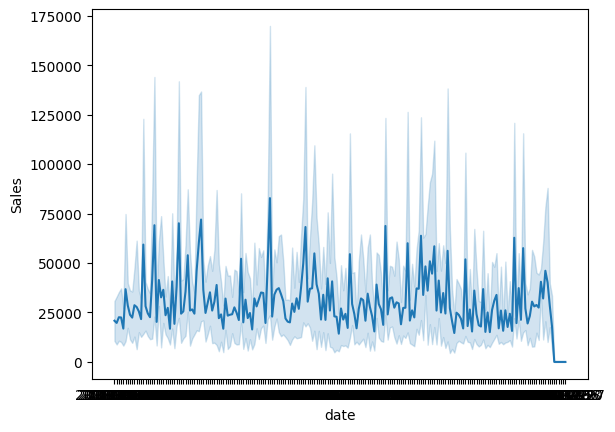

In [37]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [38]:
#df_copy = df.copy()
df_copy = df
df_copy2 = df

In [39]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [40]:
df1=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [41]:
df2=spark.read.option("header",True) \
           .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU2")

In [42]:
df3=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU3")

In [43]:
df4=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU4")

In [44]:
df5=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU5")

In [45]:
df6=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU6")

In [46]:
#df_all = spark.read.parquet("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [47]:
products = [df1,df2,df3,df4,df5,df6]

In [48]:
for i in range(len(products)):
  print(products[i].head())
  products[i].printSchema()
  products[i].show()
  products[i]= products[i].toPandas()

Row(date='2017-02-05', Sales='27750', Price_Discount='0', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')
root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price_Discount: string (nullable = true)
 |-- In-Store_Promo: string (nullable = true)
 |-- Catalogue_Promo: string (nullable = true)
 |-- Store_End_Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- Holiday_Flag: string (nullable = true)

+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|2017-02-05| 27750|             0|             0|          

In [49]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [50]:
#def convert_to_int(value):
    #try:
       # return int(float(value))
    #except ValueError:
        #return 0

In [51]:
#def convert_to_int(value):
    #try:
        #return int(float(value))
    #except ValueError:
        #return np.nan

In [52]:
df1.dtypes

[('date', 'string'),
 ('Sales', 'string'),
 ('Price_Discount', 'string'),
 ('In-Store_Promo', 'string'),
 ('Catalogue_Promo', 'string'),
 ('Store_End_Promo', 'string'),
 ('Google_Mobility', 'string'),
 ('Covid_Flag', 'string'),
 ('Holiday_Flag', 'string')]

In [53]:
#for i in products:
 # print(i.head())
  #df1['Price_Discount']=df1['Price_Discount'].str.rstrip('%').astype(float)/100
  #df1 = df1.withColumn("Price_Discount", col("Price_Discount").cast("int"))
  #print(df1.head())

In [54]:

'''df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)'''

"df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)"

In [55]:

  #i['Price_Discount']= i['Price_Discount'].str[:-1]

  #i['Price_Discount']= i['Price_Discount'].astype(int)

In [56]:
for i in products:
  print(i.head())

         date  Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0  2017-02-05  27750              0              0               0   
1  2017-02-12  29023              0              1               0   
2  2017-02-19  45630             17              0               0   
3  2017-02-26  26789              0              1               0   
4  2017-03-05  41999             17              0               0   

  Store_End_Promo Google_Mobility Covid_Flag Holiday_Flag  
0               0             0.0          0            0  
1               1             0.0          0            1  
2               0             0.0          0            0  
3               1             0.0          0            0  
4               0             0.0          0            0  
         date Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0  2017-02-05  7180             25              1               0   
1  2017-02-12  7080             25              0               0   
2  2017-02-1

In [57]:
df1.head()

Row(date='2017-02-05', Sales='27750', Price_Discount='0', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')

In [58]:
!pip install --upgrade pandas

In [59]:
cols=['Sales','In-Store_Promo','Catalogue_Promo','Store_End_Promo','Google_Mobility','Covid_Flag','Holiday_Flag']
for i in range(len(products)):
  products[i] = ps.DataFrame(products[i])
  products[i]['Price_Discount']=products[i]['Price_Discount'].apply(pd.to_numeric)
  products[i]['Sales']=products[i]['Sales'].apply(pd.to_numeric)
  products[i]['In-Store_Promo']=products[i]['In-Store_Promo'].astype('category')
  products[i]['Catalogue_Promo']=products[i]['Catalogue_Promo'].astype('category')
  products[i]['Store_End_Promo']=products[i]['Store_End_Promo'].astype('category')
  products[i]['Google_Mobility']=products[i]['Google_Mobility'].apply(pd.to_numeric)
  products[i]['Covid_Flag']=products[i]['Covid_Flag'].astype('category')
  products[i]['Holiday_Flag']=products[i]['Holiday_Flag'].astype('category')
  #i['date']=i['date'].apply(pd.to_datetime,axis=1)
  print(products[i].dtypes)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1697: FutureWarning: Argument `na_sentinel` will be removed in 4.0.0.
  warnings.warn(


date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object


In [60]:
for i in products:
  print(i.dtypes)

date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_

Product : 1


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local

Product : 2


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local

Product : 3


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Product : 4


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local

Product : 5


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-pack

Product : 6


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


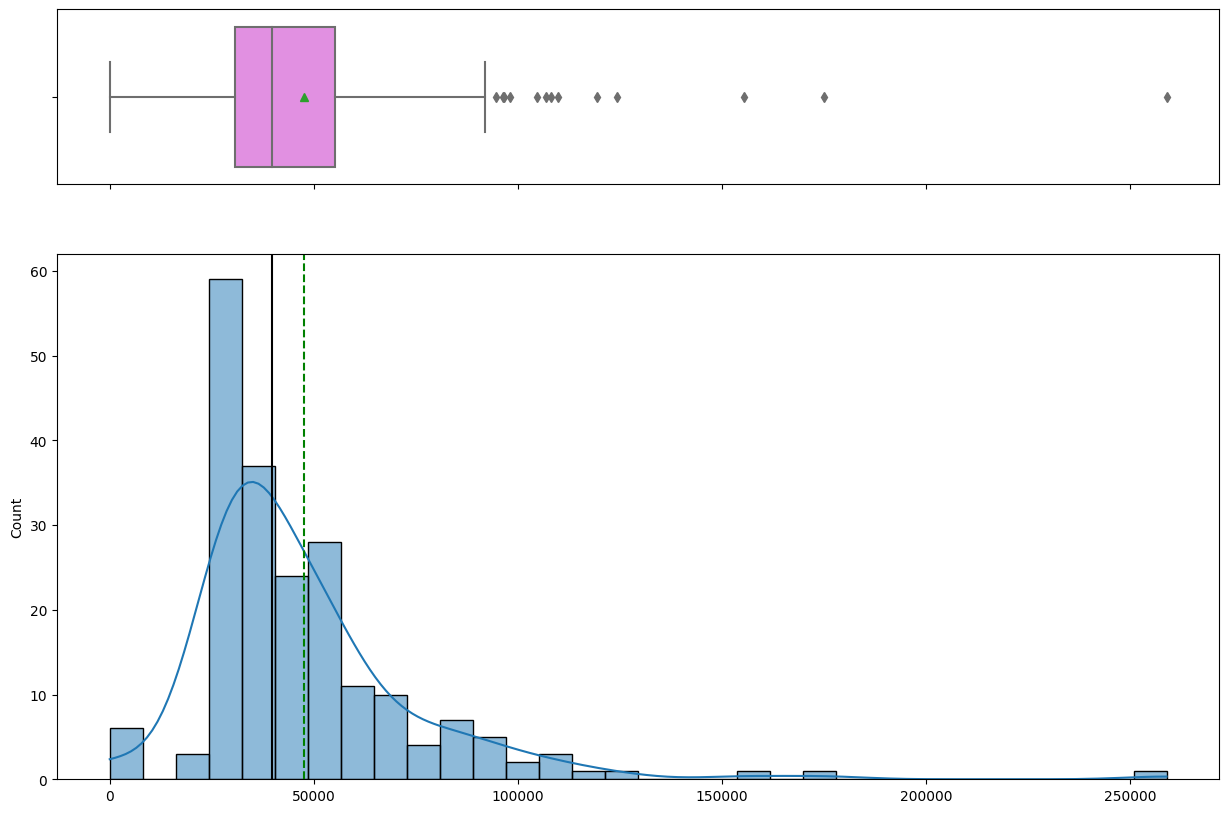

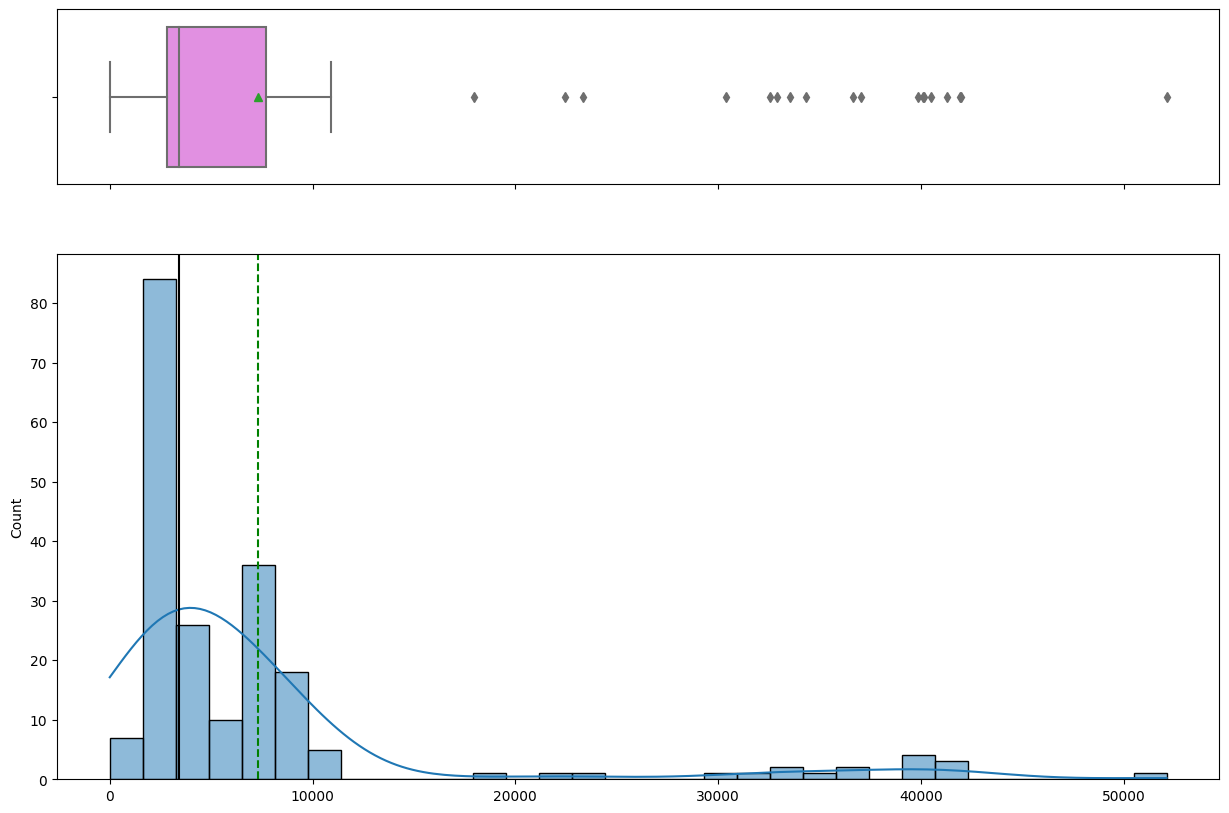

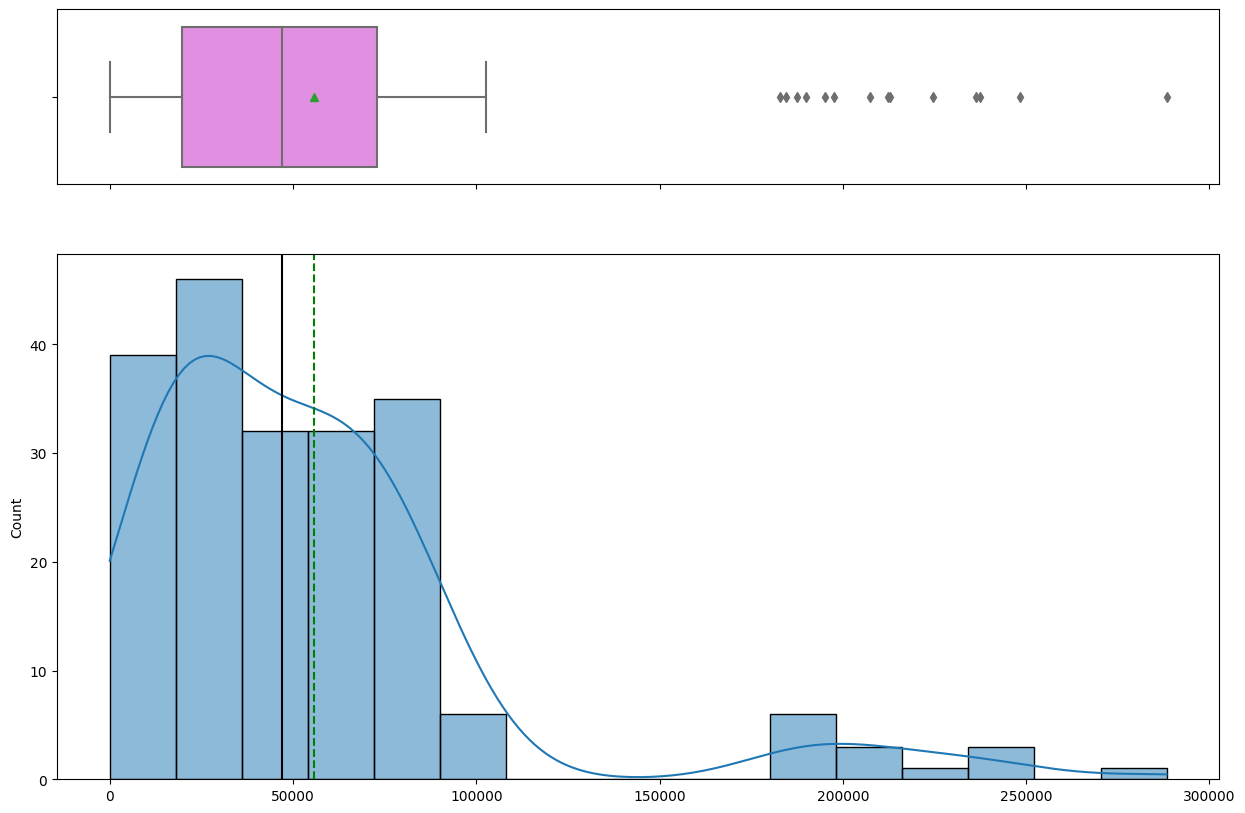

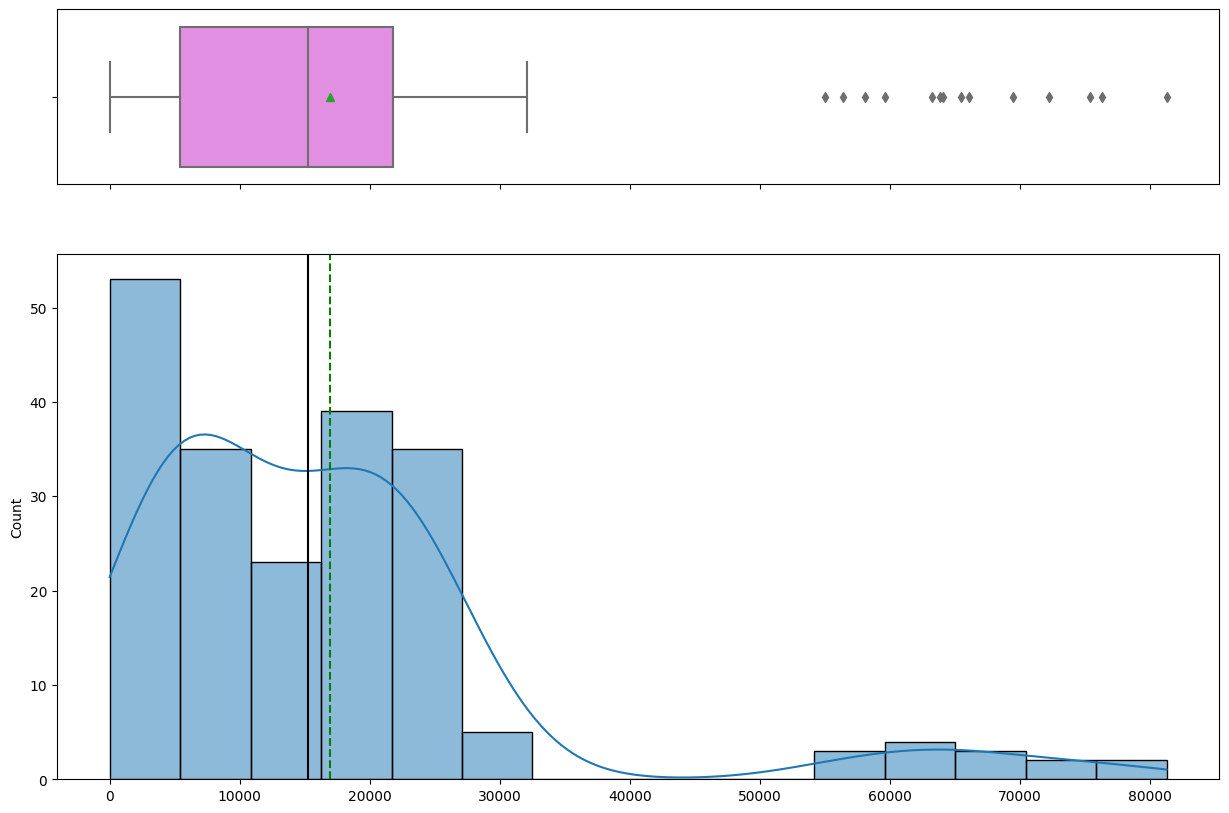

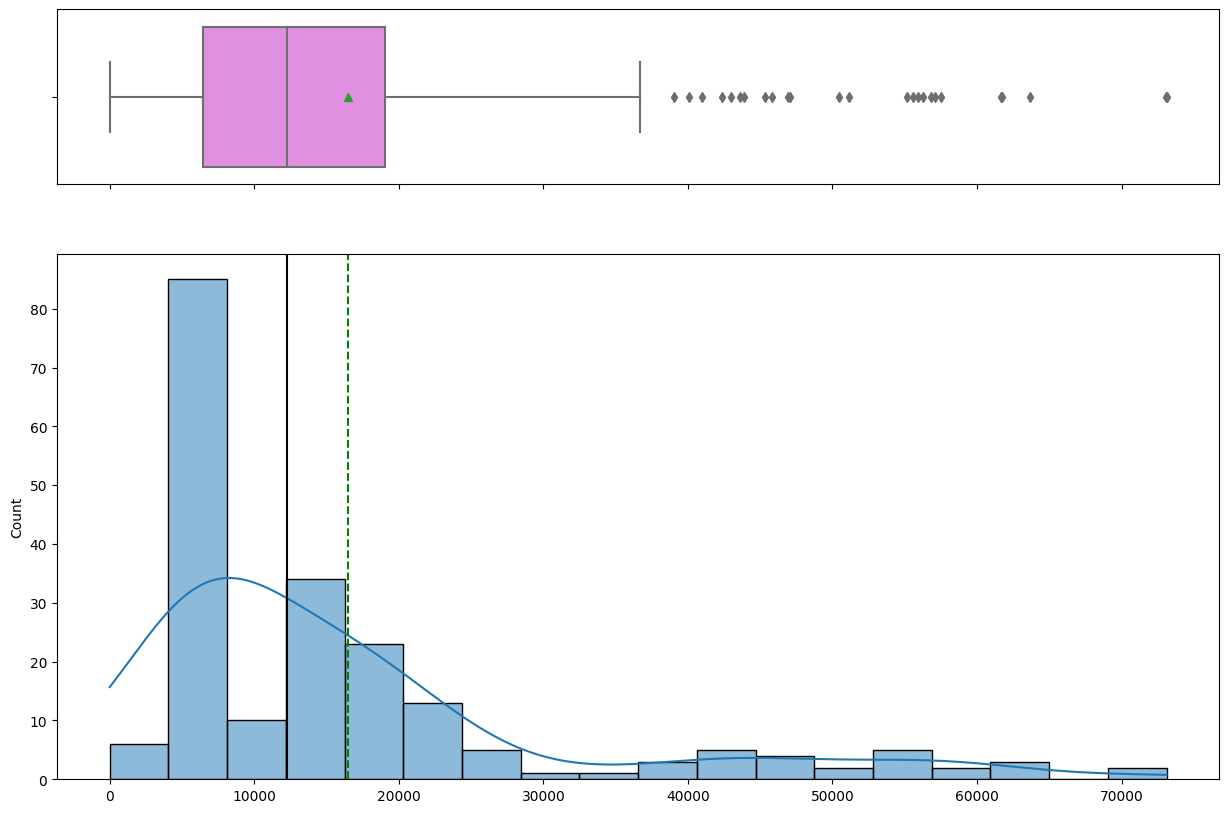

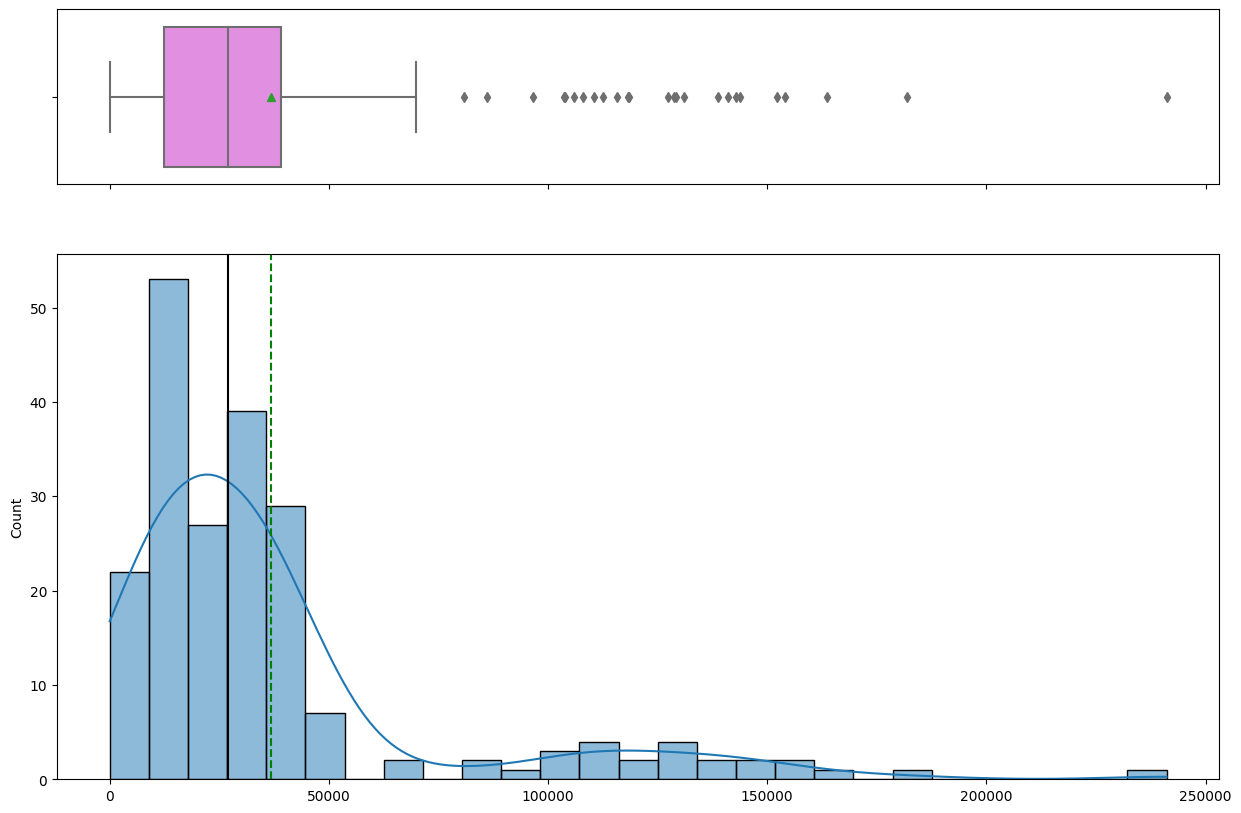

In [61]:
for i in range(len(products)):
  print('Product :',i+1)
  histplot_boxplot(products[i]['Sales'].to_numpy())
  products[i].describe

In [62]:
#from pyspark.sql.functions import col, exp

In [63]:
#q_hi  = df1['Sales'].quantile(0.99)
#for i in range(len(products)):

  #quantiles = products[i].approxQuantile('Sales', [0.25, 0.75], 0.01)
  #q1, q3 = quantiles[0], quantiles[1]
  #iqr = q3 - q1

  # Define the upper and lower bounds for outliers
  #lower_bound = q1 - 1.5 * iqr
  #upper_bound = q3 + 1.5 * iqr

  #'''Q1 = np.percentile(products[i]['Sales'], 25, method='midpoint')
  #Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
  #IQR = Q3 - Q1
  #print(IQR)
  #upper= 1.0*IQR #make the range of outliers narrower.
  #df1 = df1[(df1['Sales'] < upper)]'''

In [64]:
import pandas as pd

In [65]:
cols=['Sales','In-Store_Promo','Catalogue_Promo','Store_End_Promo','Google_Mobility','Covid_Flag','Holiday_Flag']
for i in range(len(products)):
  products[i] = ps.DataFrame(products[i])
  products[i]['Price_Discount']=products[i]['Price_Discount'].apply(pd.to_numeric)
  products[i]['Sales']=products[i]['Sales'].apply(pd.to_numeric)
  products[i]['In-Store_Promo']=products[i]['In-Store_Promo'].astype('category')
  products[i]['Catalogue_Promo']=products[i]['Catalogue_Promo'].astype('category')
  products[i]['Store_End_Promo']=products[i]['Store_End_Promo'].astype('category')
  products[i]['Google_Mobility']=products[i]['Google_Mobility'].apply(pd.to_numeric)
  products[i]['Covid_Flag']=products[i]['Covid_Flag'].astype('category')
  products[i]['Holiday_Flag']=products[i]['Holiday_Flag'].astype('category')
  #i['date']=i['date'].apply(pd.to_datetime,axis=1)
  print(products[i].dtypes)

date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object
date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_

In [66]:
df1.dtypes

[('date', 'string'),
 ('Sales', 'string'),
 ('Price_Discount', 'string'),
 ('In-Store_Promo', 'string'),
 ('Catalogue_Promo', 'string'),
 ('Store_End_Promo', 'string'),
 ('Google_Mobility', 'string'),
 ('Covid_Flag', 'string'),
 ('Holiday_Flag', 'string')]

In [67]:
#products = [df1,df2,df3,df4,df5,df6]

In [68]:
df1_2 = products[0]
df2_2 = products[1]
df3_2 = products[2]
df4_2 = products[3]
df5_2= products[4]
df6_2 = products[5]

In [69]:
df1_2.dtypes

date                 object
Sales                 int64
Price_Discount        int64
In-Store_Promo     category
Catalogue_Promo    category
Store_End_Promo    category
Google_Mobility     float64
Covid_Flag         category
Holiday_Flag       category
dtype: object

In [70]:
df1_2.to_csv("check1.csv", index = False)
df2_2.to_csv("check2.csv", index = False)
df3_2.to_csv("check3.csv", index = False)
df4_2.to_csv("check4.csv", index = False)
df5_2.to_csv("check5.csv", index = False)
df6_2.to_csv("check6.csv", index = False)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [71]:
df1_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df1_2.csv')
df2_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df2_2.csv')
df3_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df3_2.csv')
df4_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df4_2.csv')
df5_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df5_2.csv')
df6_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df6_2.csv')

In [72]:
Q1 = np.percentile(df1_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df1_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df1_2 = df1_2[(df1_2['Sales'] < upper)]

24606.0


In [73]:
df1_exclude= df1_2.iloc[:, 1:]

In [74]:
import csv
import os

In [75]:
with open('/content/drive/MyDrive/Data_Glacier/Week11/df1_2.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)

['date', 'Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']
['2/5/2017', '27750', '0', '0', '0', '0', '0', '0', '0']
['2/12/2017', '29023', '0', '1', '0', '1', '0', '0', '1']
['2/19/2017', '45630', '17', '0', '0', '0', '0', '0', '0']
['2/26/2017', '26789', '0', '1', '0', '1', '0', '0', '0']
['3/5/2017', '41999', '17', '0', '0', '0', '0', '0', '0']
['3/12/2017', '29731', '0', '0', '0', '0', '0', '0', '0']
['3/19/2017', '27365', '0', '1', '0', '0', '0', '0', '0']
['3/26/2017', '27722', '0', '1', '0', '1', '0', '0', '0']
['4/2/2017', '44339', '17', '1', '0', '0', '0', '0', '0']
['4/9/2017', '54655', '17', '1', '0', '0', '0', '0', '1']
['4/16/2017', '108159', '44', '0', '0', '0', '0', '0', '0']
['4/23/2017', '30361', '0', '1', '0', '1', '0', '0', '0']
['4/30/2017', '42154', '17', '1', '0', '1', '0', '0', '0']
['5/7/2017', '39782', '17', '0', '0', '0', '0', '0', '0']
['5/14/2017', '29490', '0', '0', '0', '0', '

In [76]:
#import pandas as pd
# CSVファイルをデータフレームとして読み込む
#df1_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df1_2.csv'")
#df2_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df2_2.csv'")
#df3_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df3_2.csv'")
#df4_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df4_2.csv'")
#df5_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df5_2.csv'")
#df6_2 = pd.read_csv("'/content/drive/MyDrive/Data_Glacier/Week11/df6_2.csv'")



In [77]:
#Adding Product columns to each dataset.

df1_2['Product'] = 'SKU1'
df2_2['Product'] = 'SKU2'
df3_2['Product'] = 'SKU3'
df4_2['Product'] = 'SKU4'
df5_2['Product'] = 'SKU5'
df6_2['Product'] = 'SKU6'

print(df1_2)

           date  Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
181   7/26/2020  23891               1               0                0   
183    8/9/2020  24543               1               0                0   
184   8/16/2020  23744               1               0                0   
185   8/23/2020  23606               1               0                0   
186   8/30/2020  24346               1               1                0   
198  11/22/2020      0              12               1                0   
199  11/29/2020      0              16               1                0   
200   12/6/2020      0              15               1                0   
201  12/13/2020      0              14               1                0   
202  12/20/2020      0              15               1                0   
203  12/27/2020      0              15               1                0   

     Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag Product  
181                0     

<ipython-input-77-72ab5054c016>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_2['Product'] = 'SKU1'


In [78]:

# データフレームを縦方向に結合
result = pd.concat([df1_2, df2_2, df3_2, df4_2, df5_2, df6_2,], axis=0)
# 結果を表示
print(result)
# 結果をCSVファイルに保存
result.to_csv("combined.csv", index=False)

           date  Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
181   7/26/2020  23891               1               0                0   
183    8/9/2020  24543               1               0                0   
184   8/16/2020  23744               1               0                0   
185   8/23/2020  23606               1               0                0   
186   8/30/2020  24346               1               1                0   
..          ...    ...             ...             ...              ...   
199  11/29/2020      0               0               0                0   
200   12/6/2020      0               0               0                0   
201  12/13/2020      0               0               0                0   
202  12/20/2020      0               0               0                0   
203  12/27/2020      0               0               0                0   

     Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag Product  
181                0     

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


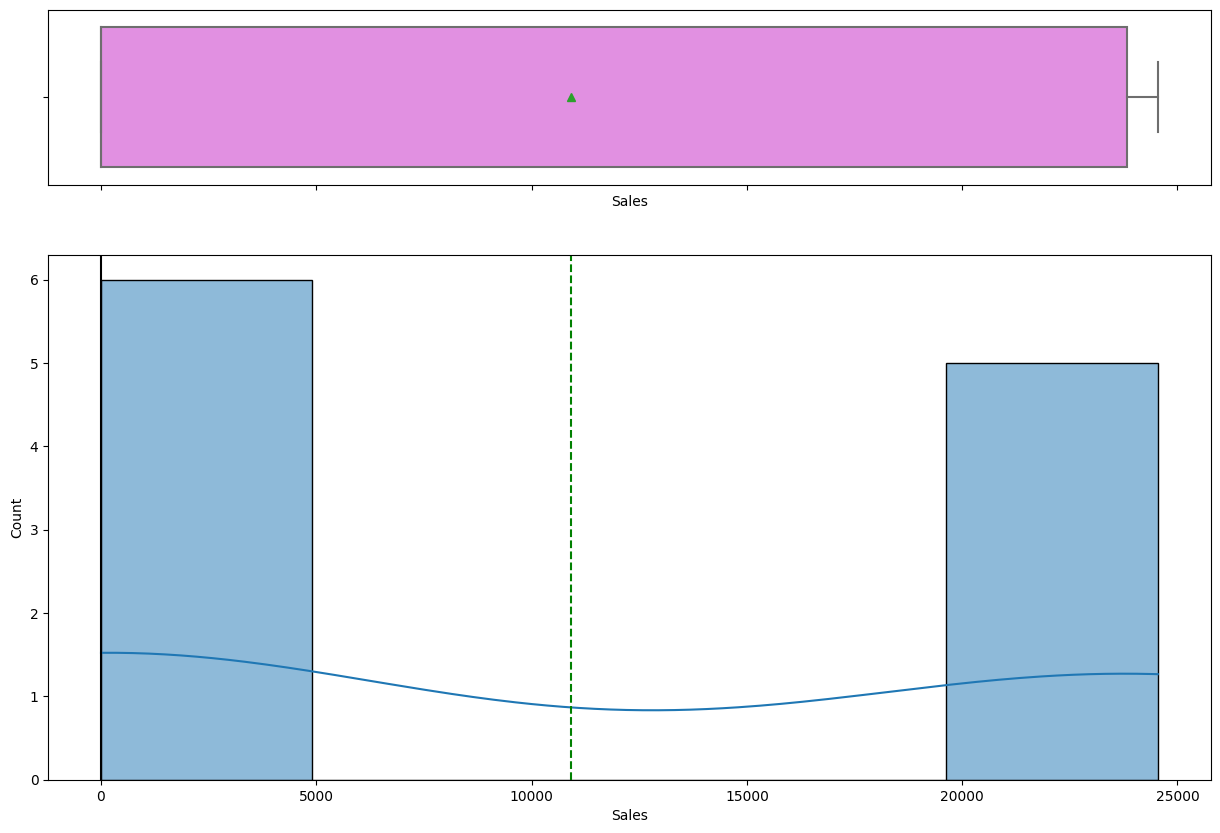

In [79]:
histplot_boxplot(df1_2['Sales'])

In [80]:
df2_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [81]:
Q1 = np.percentile(df2_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df2_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df2_2 = df2_2[(df2_2['Sales'] < upper)]

4891.0


In [82]:
df2_exclude= df2_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


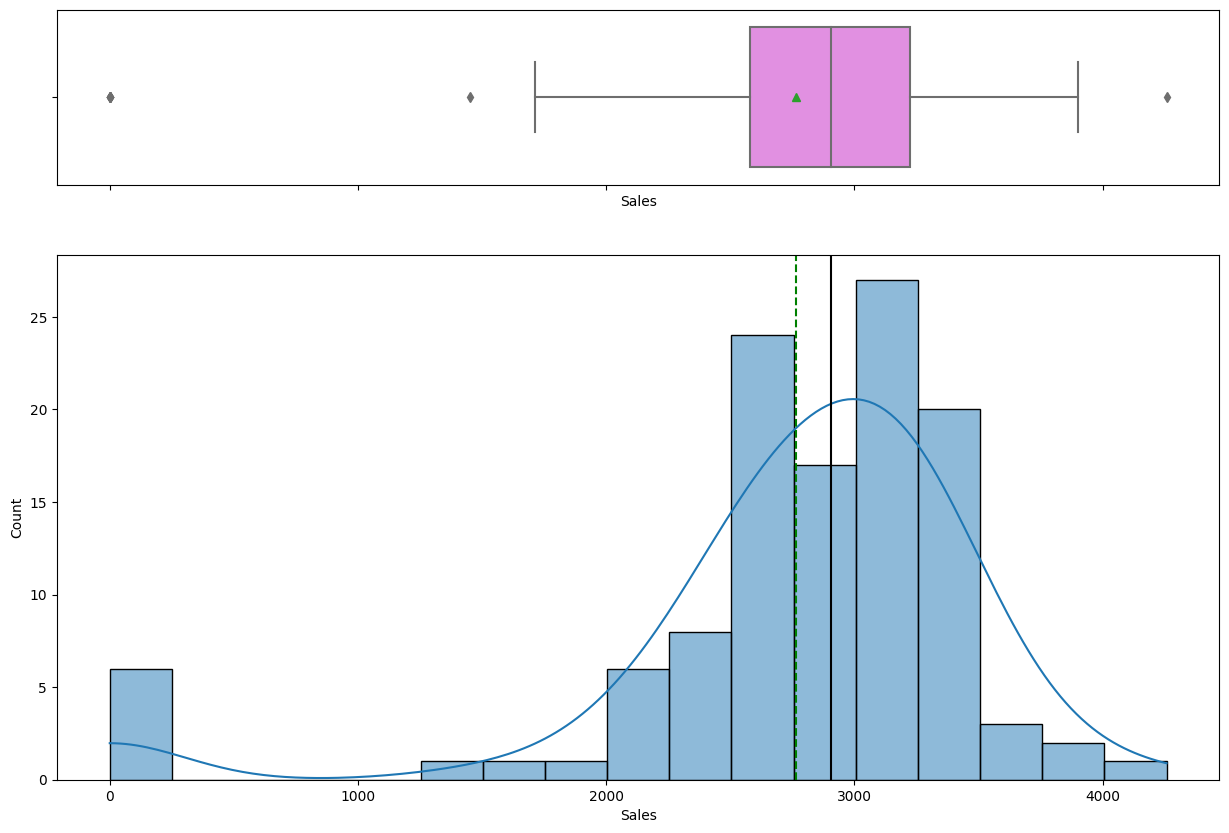

In [83]:
histplot_boxplot(df2_2['Sales'])

In [84]:
df3_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [85]:
Q1 = np.percentile(df3_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df3_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df3_2 = df3_2[(df3_2['Sales'] < upper)]

53491.5


In [86]:
df3_exclude= df3_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


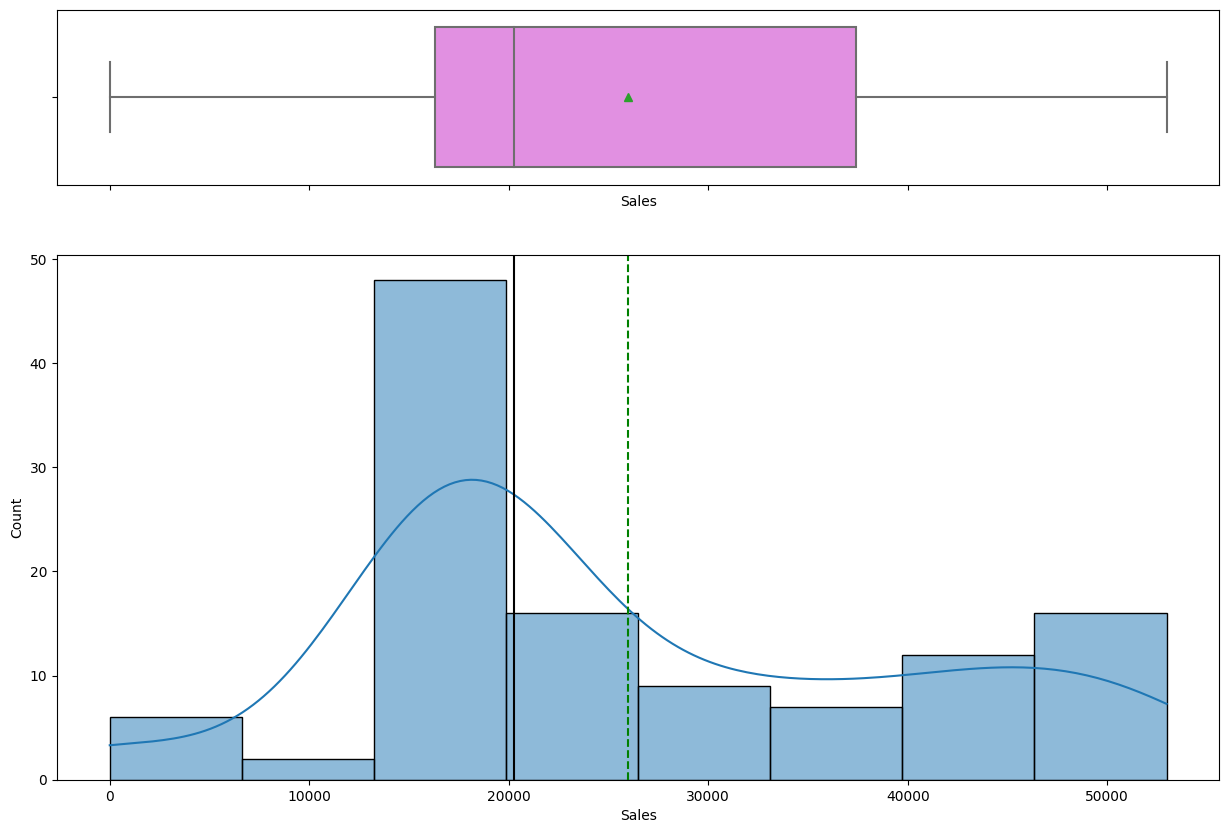

In [87]:
histplot_boxplot(df3_2['Sales'])

In [88]:
df4_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [89]:
Q1 = np.percentile(df4_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df4_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df4_2 = df4_2[(df4_2['Sales'] < upper)]

16423.5


In [90]:
df4_exclude= df4_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


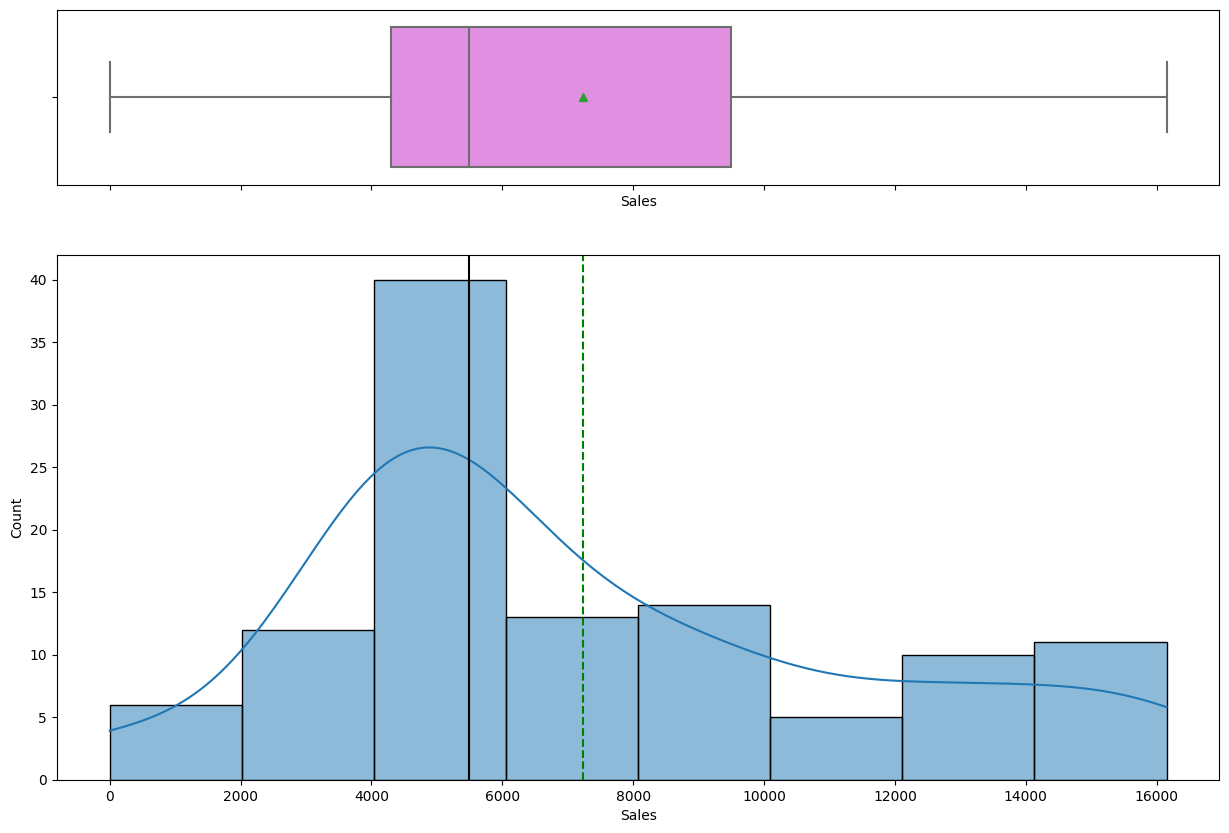

In [91]:
histplot_boxplot(df4_2['Sales'])

In [92]:
df5_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [93]:
Q1 = np.percentile(df5_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df5_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df5_2 = df5_2[(df5_2['Sales'] < upper)]

12673.5


In [94]:
df5_exclude= df5_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


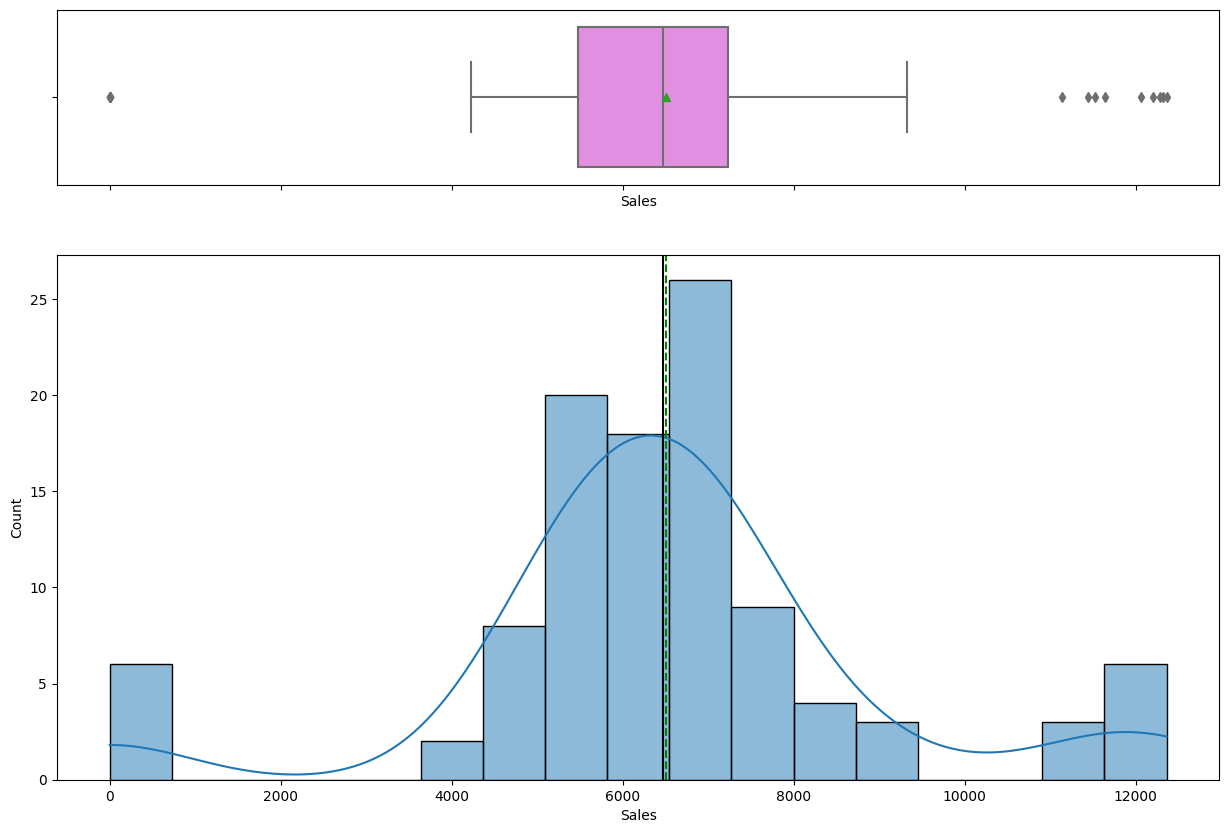

In [95]:
histplot_boxplot(df5_2['Sales'])

In [96]:
df6_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [97]:
Q1 = np.percentile(df6_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df6_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df6_2 = df6_2[(df6_2['Sales'] < upper)]

26869.0


In [98]:
df6_exclude= df6_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-49-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


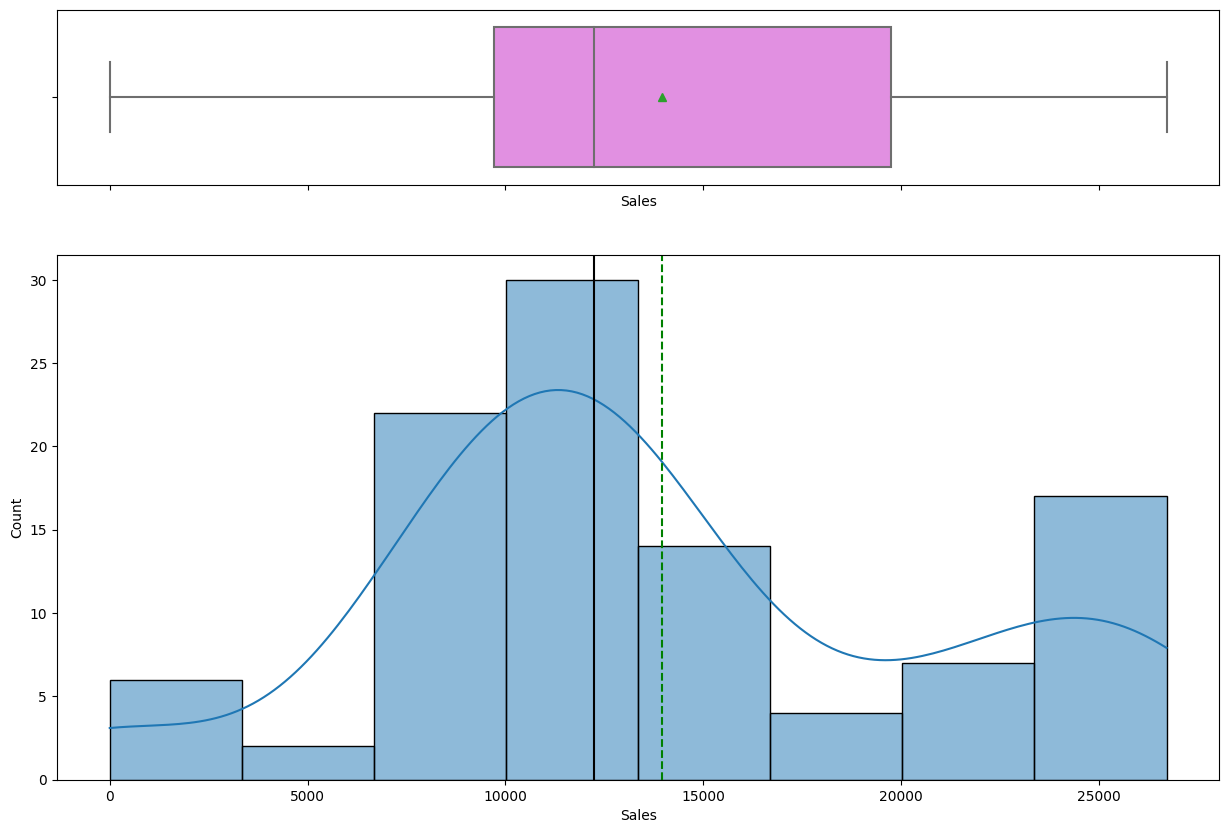

In [99]:
histplot_boxplot(df6_2['Sales'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

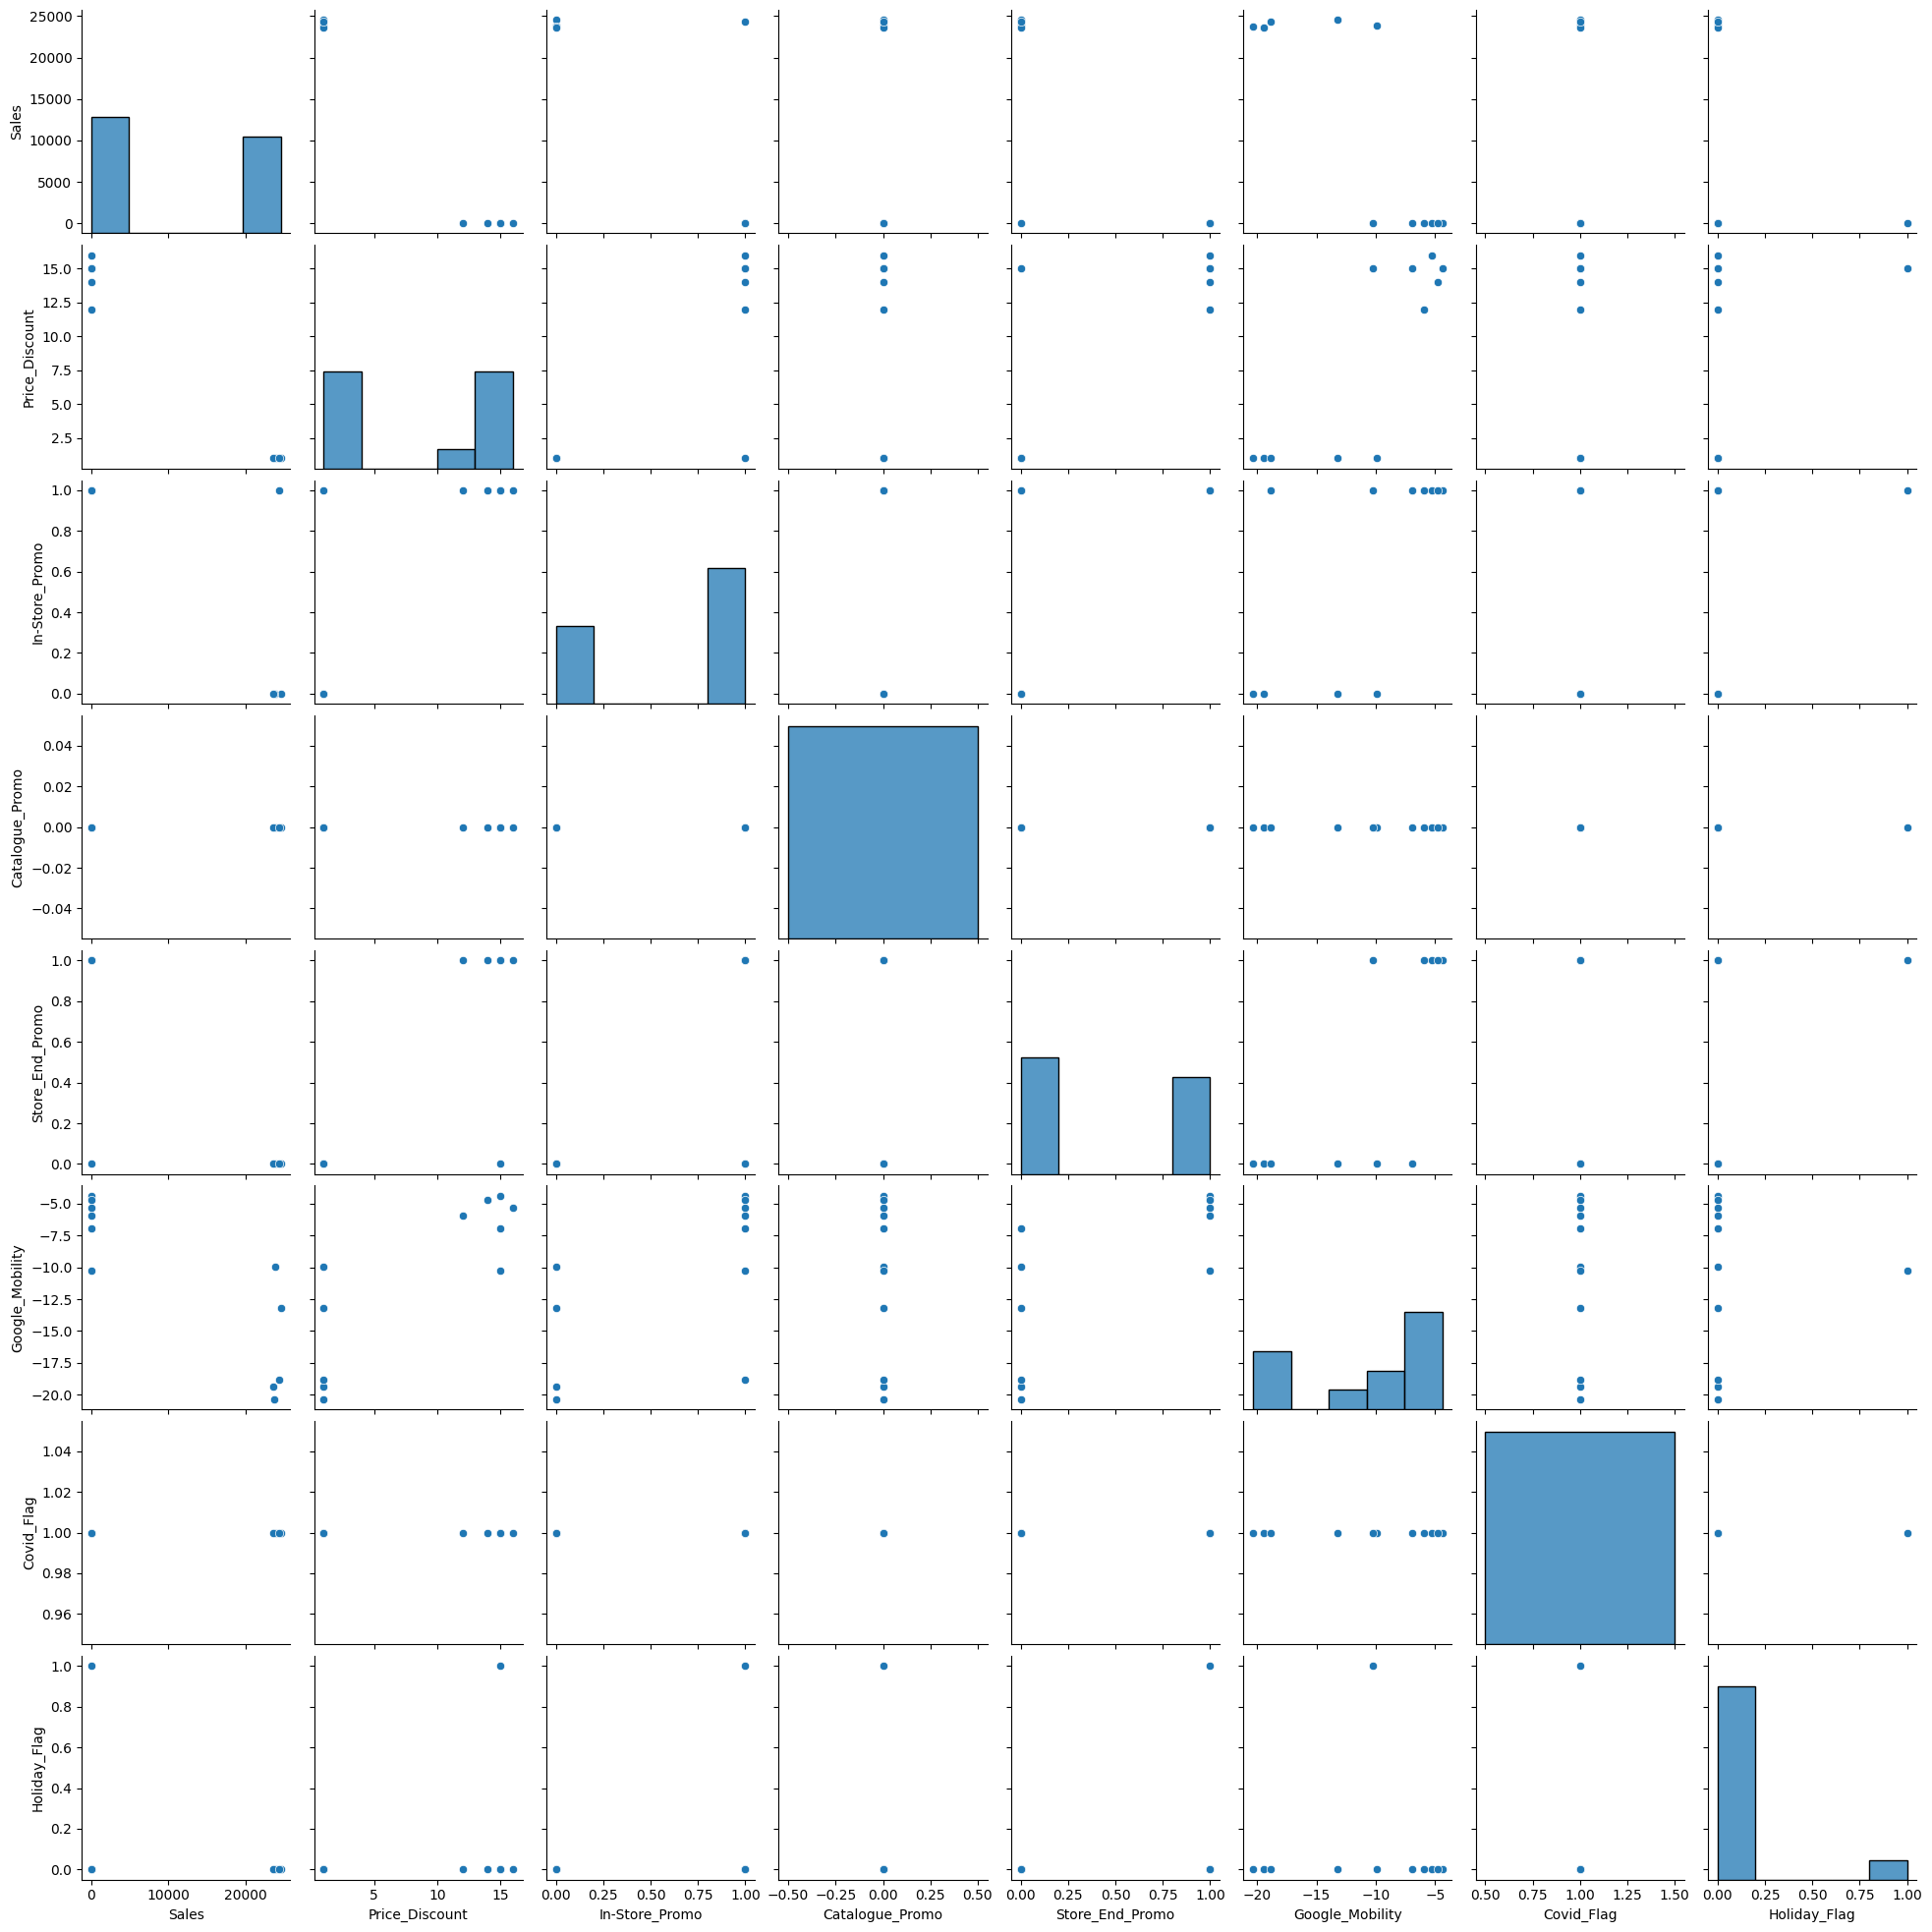

In [100]:
sns.pairplot(data=df1_2.iloc[:, 1:])

In [101]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [102]:
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)
adf_test(df1_2['Sales'])

1. ADF :  -1.0076188092748983
2. P-Value :  0.7504753824440884
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 10
5. Critical Values :
	 1% :  -4.331573
	 5% :  -3.23295
	 10% :  -2.7487


In [103]:
df1_2["Sales"].astype(int)

181    23891
183    24543
184    23744
185    23606
186    24346
198        0
199        0
200        0
201        0
202        0
203        0
Name: Sales, dtype: int64

In [104]:
df1_2['Sales'] = pd.to_numeric(df1_2['Sales'])
df1_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [105]:
df1_2.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
181,7/26/2020,23891,1,0,0,0,-9.93,1,0,SKU1
183,8/9/2020,24543,1,0,0,0,-13.23,1,0,SKU1
184,8/16/2020,23744,1,0,0,0,-20.35,1,0,SKU1
185,8/23/2020,23606,1,0,0,0,-19.41,1,0,SKU1
186,8/30/2020,24346,1,1,0,0,-18.83,1,0,SKU1


In [106]:
#df1_2['Sales'] = pd.to_numeric(df1_2['Sales'])
#df1_2.dtypes

In [107]:
el_df=df1_2.set_index('date')

In [108]:
print(df1_2)

           date  Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
181   7/26/2020  23891               1               0                0   
183    8/9/2020  24543               1               0                0   
184   8/16/2020  23744               1               0                0   
185   8/23/2020  23606               1               0                0   
186   8/30/2020  24346               1               1                0   
198  11/22/2020      0              12               1                0   
199  11/29/2020      0              16               1                0   
200   12/6/2020      0              15               1                0   
201  12/13/2020      0              14               1                0   
202  12/20/2020      0              15               1                0   
203  12/27/2020      0              15               1                0   

     Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag Product  
181                0     

In [109]:
print(el_df)

            Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
date                                                                 
7/26/2020   23891               1               0                0   
8/9/2020    24543               1               0                0   
8/16/2020   23744               1               0                0   
8/23/2020   23606               1               0                0   
8/30/2020   24346               1               1                0   
11/22/2020      0              12               1                0   
11/29/2020      0              16               1                0   
12/6/2020       0              15               1                0   
12/13/2020      0              14               1                0   
12/20/2020      0              15               1                0   
12/27/2020      0              15               1                0   

            Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag Product  
date    

In [110]:
! python3 -mpip install matplotlib

In [111]:
! pip install matplotlib

In [112]:
import matplotlib.pyplot as plt

import matplotlib
#matplotlib.use('matplotlib')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

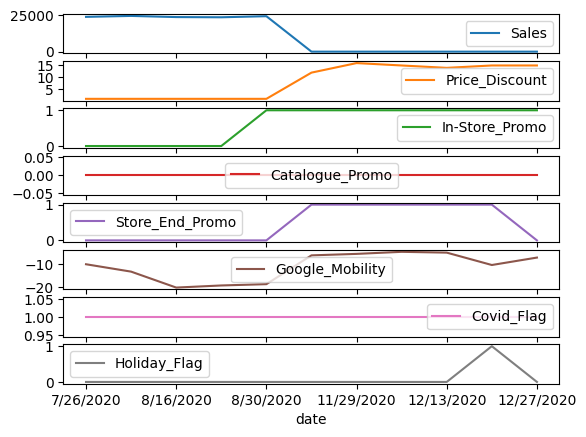

In [113]:
el_df.plot(subplots=True)

In [114]:
#from datetime import datetime
#el_df['date']=pd.to_datetime(el_df['date'],infer_datetime_format=True)

In [115]:
#el_df=df1_2.set_index('date')
#df1_2=df1_2.set_index('date')

In [116]:
#df1_2.resample('M').mean()

#df = Transit.resample('D', on='Timestamp').mean()
#print (df)

In [117]:
print ("\nMissing values :  ", df1_2.isnull().any())


Missing values :   date               False
Sales              False
Price_Discount     False
In-Store_Promo     False
Catalogue_Promo    False
Store_End_Promo    False
Google_Mobility    False
Covid_Flag         False
Holiday_Flag       False
Product            False
dtype: bool


In [118]:
#el_df.resample('M').mean().plot(subplots=True)

In [119]:
#final_df=el_df.resample('M').mean()

In [120]:
#final_df.isnull().any()

In [121]:
#final_df1=final_df.dropna()

#final_df1.isna().sum()

In [122]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df2test = adfuller(dataset, autolag = 'AIC')
     #df2test = adfuller(dataset.diff()[1:])
     print("1. ADF : ",df2test[0])
     print("2. P-Value : ", df2test[1])
     print("3. Num Of Lags : ", df2test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df2test[3])
     print("5. Critical Values :")
     for key, val in df2test[4].items():
         print("\t",key, ": ", val)
adf_test(df2_2['Sales'])

1. ADF :  -2.4102471662160756
2. P-Value :  0.13886508482595517
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 116
5. Critical Values :
	 1% :  -3.4880216384691867
	 5% :  -2.8867966864160075
	 10% :  -2.5802408234244947


In [123]:
df2_2["Sales"].astype(int)

2      2753
3      3062
5      3124
7      3226
9      3084
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 117, dtype: int64

In [124]:
df2_2['Sales'] = pd.to_numeric(df2_2['Sales'])
df2_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [125]:
el_df2=df2_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

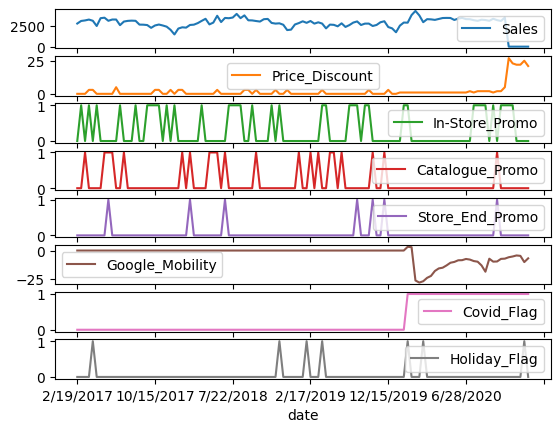

In [126]:
el_df2.plot(subplots=True)

In [127]:
#el_df2.resample('M').mean()

In [128]:
#print ("\nMissing values :  ", df2.isnull().any())

#el_df2.resample('M').mean().plot(subplots=True)

#final_df2=el_df2.resample('M').mean()

In [129]:
#final_df2.isnull().any()

In [130]:
#final_df2=final_df2.dropna()

#final_df2.isna().sum()

In [131]:
#rolling_mean = final_df2['Sales'].rolling(window=12).mean()  # Calculate the 12-month moving average
#detrended_data2 = final_df2['Sales'] - rolling_mean
#adf_test(detrended_data2.dropna())

**Observation**  
P-value became 0.05 that provides the data is stationary.  

In [132]:
def adf_test(dataset):
     df3test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df3test[0])
     print("2. P-Value : ", df3test[1])
     print("3. Num Of Lags : ", df3test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df3test[3])
     print("5. Critical Values :")
     for key, val in df3test[4].items():
         print("\t",key, ": ", val)
adf_test(df3_2['Sales'])

1. ADF :  -2.732775025967565
2. P-Value :  0.06853643571804792
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 110
5. Critical Values :
	 1% :  -3.4912451337340342
	 5% :  -2.8881954545454547
	 10% :  -2.5809876033057852


In [133]:
df3_2["Sales"].astype(int)

0      39767
1      49090
2      41044
4      13568
5      48230
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 116, dtype: int64

In [134]:
df3_2['Sales'] = pd.to_numeric(df3_2['Sales'])
df3_2.dtypes


date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [135]:
el_df3_2=df3_2.set_index('date')


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

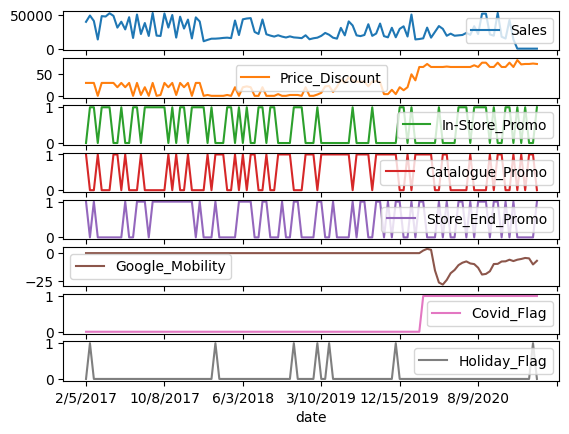

In [136]:
el_df3_2.plot(subplots=True)


In [137]:
#el_df3.resample('M').mean()

In [138]:
#print ("\nMissing values :  ", df3.isnull().any())

#el_df3.resample('M').mean().plot(subplots=True)

#final_df3=el_df.resample('M').mean()

In [139]:
#final_df3.isnull().any()

In [140]:
#final_df3=final_df3.dropna()

#final_df3.isna().sum()

In [141]:
def adf_test(dataset):
     df4test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df4test[0])
     print("2. P-Value : ", df4test[1])
     print("3. Num Of Lags : ", df4test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df4test[3])
     print("5. Critical Values :")
     for key, val in df4test[4].items():
         print("\t",key, ": ", val)
adf_test(df4_2['Sales'])

1. ADF :  -2.9267011767455893
2. P-Value :  0.0423299564919738
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 108
5. Critical Values :
	 1% :  -3.4924012594942333
	 5% :  -2.8886968193364835
	 10% :  -2.5812552709190673


In [142]:
df4_2["Sales"].astype(int)

0      12835
1      15705
2      13382
3      15709
4       3729
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 111, dtype: int64

In [143]:
df4_2['Sales'] = pd.to_numeric(df4_2['Sales'])
df4_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [144]:
el_df4=df4_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

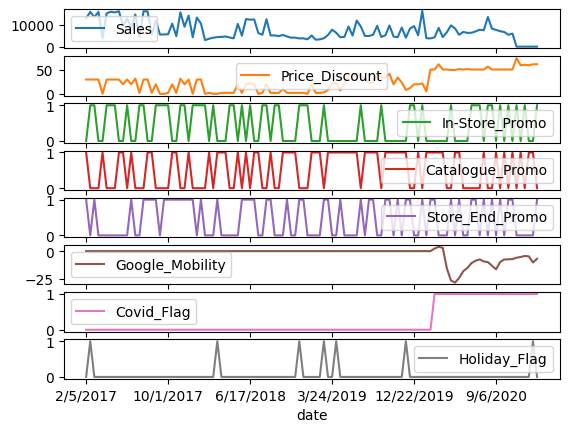

In [145]:
el_df4.plot(subplots=True)

In [146]:
#el_df4.resample('M').mean()

In [147]:
#print ("\nMissing values :  ", df4.isnull().any())

#el_df4.resample('M').mean().plot(subplots=True)

#final_df4=el_df4.resample('M').mean()

In [148]:
#final_df4.isnull().any()

In [149]:
#final_df4=final_df4.dropna()

#final_df4.isna().sum()

In [150]:
def adf_test(dataset):
     df5test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df5test[0])
     print("2. P-Value : ", df5test[1])
     print("3. Num Of Lags : ", df5test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df5test[3])
     print("5. Critical Values :")
     for key, val in df5test[4].items():
         print("\t",key, ": ", val)
adf_test(df5_2['Sales'])

1. ADF :  -5.223830770998545
2. P-Value :  7.858760353568244e-06
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 104
5. Critical Values :
	 1% :  -3.4948504603223145
	 5% :  -2.889758398668639
	 10% :  -2.5818220155325444


In [151]:
df5_2["Sales"].astype(int)

0      5229
1      5748
3      5928
5      5952
6      5994
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 105, dtype: int64

In [152]:
df5_2['Sales'] = pd.to_numeric(df5_2['Sales'])
df5_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [153]:
el_df5=df5_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

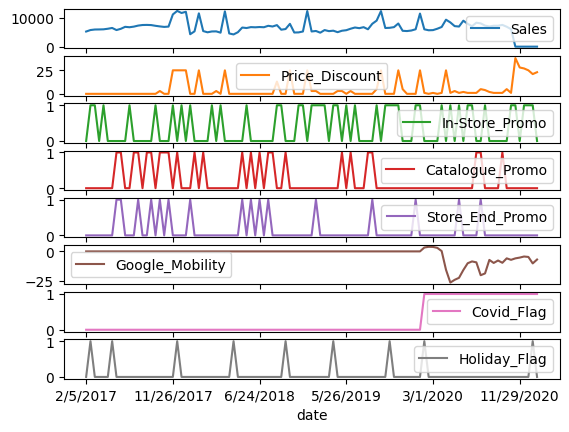

In [154]:
el_df5.plot(subplots=True)

In [155]:
#el_df5.resample('M').mean()

In [156]:
#print ("\nMissing values :  ", df5.isnull().any())

#el_df5.resample('M').mean().plot(subplots=True)

#final_df5=el_df5.resample('M').mean()

In [157]:
#final_df5.isnull().any()

In [158]:
#final_df5=final_df5.dropna()

#final_df5.isna().sum()

In [159]:
def adf_test(dataset):
     df6test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df6test[0])
     print("2. P-Value : ", df6test[1])
     print("3. Num Of Lags : ", df6test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df6test[3])
     print("5. Critical Values :")
     for key, val in df6test[4].items():
         print("\t",key, ": ", val)
adf_test(df6_2['Sales'])


1. ADF :  -5.07203360922023
2. P-Value :  1.5952507284889607e-05
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 100
5. Critical Values :
	 1% :  -3.497501033
	 5% :  -2.89090644
	 10% :  -2.5824349


In [160]:
df6_2["Sales"].astype(int)

1      11659
2      12140
4      11666
8      11595
10      9508
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 102, dtype: int64

In [161]:
df6_2['Sales'] = pd.to_numeric(df6_2['Sales'])
df6_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
Product             object
dtype: object

In [162]:
el_df6=df6_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

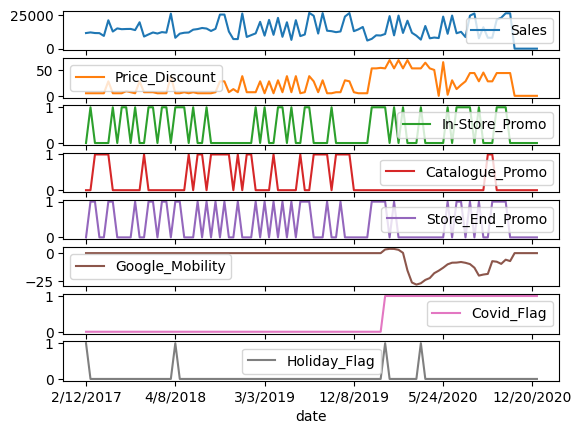

In [163]:
el_df6.plot(subplots=True)

In [164]:
#el_df6.resample('M').mean()

In [165]:
#print ("\nMissing values :  ", df6.isnull().any())

#el_df6.resample('M').mean().plot(subplots=True)

#final_df6=el_df6.resample('M').mean()

In [166]:
#final_df6.isnull().any()

In [167]:
#final_df6=final_df6.dropna()

#final_df6.isna().sum()

In [168]:
combined = pd.read_csv('/content/combined.csv')

In [169]:
combined.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
0,7/26/2020,23891,1,0,0,0,-9.93,1,0,SKU1
1,8/9/2020,24543,1,0,0,0,-13.23,1,0,SKU1
2,8/16/2020,23744,1,0,0,0,-20.35,1,0,SKU1
3,8/23/2020,23606,1,0,0,0,-19.41,1,0,SKU1
4,8/30/2020,24346,1,1,0,0,-18.83,1,0,SKU1


In [170]:
combined.tail()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
1026,11/29/2020,0,0,0,0,0,0.0,1,0,SKU6
1027,12/6/2020,0,0,0,0,0,0.0,1,0,SKU6
1028,12/13/2020,0,0,0,0,0,0.0,1,0,SKU6
1029,12/20/2020,0,0,0,0,0,0.0,1,0,SKU6
1030,12/27/2020,0,0,0,0,0,0.0,1,0,SKU6


In [171]:
combined = spark.createDataFrame(combined) #convert to pandas to PySpark frame


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [172]:
combined.show()

+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
|      date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|Product|
+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
| 7/26/2020|23891|             1|             0|              0|              0|          -9.93|         1|           0|   SKU1|
|  8/9/2020|24543|             1|             0|              0|              0|         -13.23|         1|           0|   SKU1|
| 8/16/2020|23744|             1|             0|              0|              0|         -20.35|         1|           0|   SKU1|
| 8/23/2020|23606|             1|             0|              0|              0|         -19.41|         1|           0|   SKU1|
| 8/30/2020|24346|             1|             1|              0|              0|         -18.83| 

In [173]:
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName("YourAppName").getOrCreate()

In [174]:
#from pyspark.sql.functions import col
#from pyspark.sql.types import DoubleType, IntegerType, TimestampType

# 列のデータ型を変換するためにwithColumnメソッドを使用します
#cols_to_convert = ['date', 'Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag', 'Product']

#for col_name in cols_to_convert:
    #if col_name == 'Price_Discount':
        #combined = combined.withColumn(col_name, combined[col_name].cast(DoubleType()))
    #else:
        #combined = combined.withColumn(col_name, combined[col_name].cast(IntegerType()))

# 'date'列をタイムスタンプに変換
#combined = combined.withColumn('date', combined['date'].cast(TimestampType()))

In [175]:
combined.show()

+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
|      date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|Product|
+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
| 7/26/2020|23891|             1|             0|              0|              0|          -9.93|         1|           0|   SKU1|
|  8/9/2020|24543|             1|             0|              0|              0|         -13.23|         1|           0|   SKU1|
| 8/16/2020|23744|             1|             0|              0|              0|         -20.35|         1|           0|   SKU1|
| 8/23/2020|23606|             1|             0|              0|              0|         -19.41|         1|           0|   SKU1|
| 8/30/2020|24346|             1|             1|              0|              0|         -18.83| 

In [176]:
##from pyspark.sql.functions import col, to_date
from pyspark.sql import SparkSession

# Sparkセッションを作成
#spark = SparkSession.builder.appName("pyspark_to_pandas").getOrCreate()

# 例えば、combined DataFrame内の "date" 列が文字列型として格納されていると仮定します
#combined = combined.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# これで日付型が変換されたので、Pandasに変換できる
#pandas_combined = combined.toPandas()

In [177]:
#combined.tail()

In [178]:
#pandas_combined = combined.toPandas()

In [179]:
#pandas_combined.to_csv('pandas_combined.csv', index=False)

In [180]:
spark = SparkSession.builder.appName("DataFrameExample").getOrCreate()

In [181]:
window_spec = Window.orderBy("date")
df_copy2 = df_copy2.withColumn("prev_flag", F.lag("Covid_Flag").over(window_spec))

start_dates = df_copy2.filter((F.col("Covid_Flag") == 1) & (F.col("prev_flag") == 0))

start_dates.select("Date").show()

+----------+
|      Date|
+----------+
|2020-02-09|
+----------+



**Observation**  
Covid Flag started from February 09, 2020.  

In [182]:
! pip install plotly

In [183]:
#df_vis.toPandas()

In [184]:
import plotly.express as px

#pandas_df = df_vis.toPandas()

df_copy2_pandas = df_copy2.toPandas()

fig = px.line(df_copy2_pandas, x='date', y='Google_Mobility', title='Google_Mobility')

min_desired_value = -30
max_desired_value = 10
#fig.update_yaxes(range=[min_desired_value, max_desired_value])
#fig.update_xaxes(range=[min_desired_value, max_desired_value])
fig.show()

In [185]:
import plotly.express as px

#pandas_df = df_vis.toPandas()

fig = px.line(df_vis, x='date', y='Google_Mobility', title='Google_Mobility')

min_desired_value = -30
max_desired_value = 10
fig.update_yaxes(range=[min_desired_value, max_desired_value])

fig.show()

**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

**To analyze the data pre-Covid and post-Covid, we divide the data to 2.**

In [186]:
combined.show()

+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
|      date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|Product|
+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+-------+
| 7/26/2020|23891|             1|             0|              0|              0|          -9.93|         1|           0|   SKU1|
|  8/9/2020|24543|             1|             0|              0|              0|         -13.23|         1|           0|   SKU1|
| 8/16/2020|23744|             1|             0|              0|              0|         -20.35|         1|           0|   SKU1|
| 8/23/2020|23606|             1|             0|              0|              0|         -19.41|         1|           0|   SKU1|
| 8/30/2020|24346|             1|             1|              0|              0|         -18.83| 

In [187]:
from pyspark.sql.functions import col

before_date = df_copy2.filter(col("date") < "2020-02-09")

after_date = df_copy2.filter(col("date") >= "2020-02-09")

before_date.show()
after_date.show()

+-------+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+---------+
|Product|      date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|prev_flag|
+-------+----------+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+---------+
|   SKU1|2017-02-05|27750|             0|             0|              0|              0|            0.0|         0|           0|     NULL|
|   SKU2|2017-02-05| 7180|            25|             1|              0|              0|            0.0|         0|           0|        0|
|   SKU3|2017-02-05|39767|            30|             0|              1|              1|            0.0|         0|           0|        0|
|   SKU4|2017-02-05|12835|            30|             0|              1|              1|            0.0|         0|           0|        0|
|   SKU5|2017-02-05| 5229| 

In [188]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

before_date = before_date.withColumn('Sales', col('Sales').cast(FloatType()))

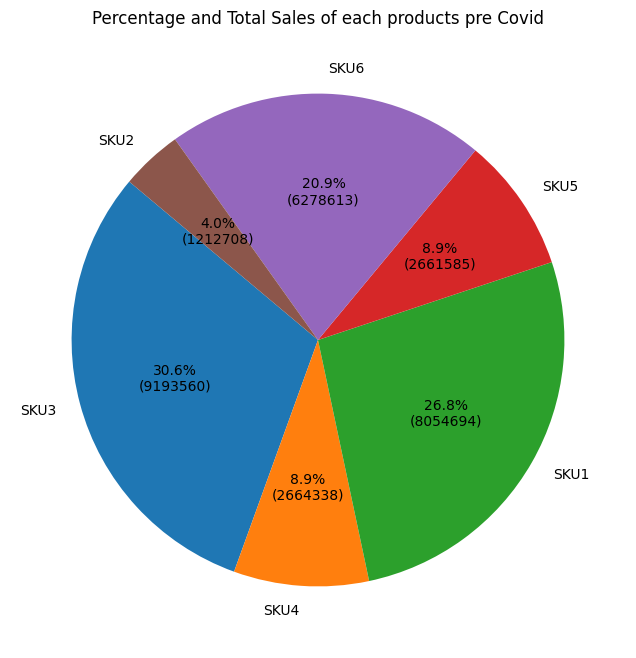

In [189]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

In [190]:
from pyspark.sql.functions import col

null_columns = [col(c).alias(c) for c in after_date.columns]

after_date.select(null_columns).filter(after_date['Sales'].isNull()).show()

+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+---------+
|Product|date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|prev_flag|
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+---------+
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+---------+



In [191]:
after_date1 = after_date.toPandas()
after_date1.isnull().any()

Product            False
date               False
Sales              False
Price_Discount     False
In-Store_Promo     False
Catalogue_Promo    False
Store_End_Promo    False
Google_Mobility    False
Covid_Flag         False
Holiday_Flag       False
prev_flag          False
dtype: bool

In [192]:
print(after_date1[after_date1['Sales'].isnull()])

Empty DataFrame
Columns: [Product, date, Sales, Price_Discount, In-Store_Promo, Catalogue_Promo, Store_End_Promo, Google_Mobility, Covid_Flag, Holiday_Flag, prev_flag]
Index: []


In [193]:
after_date = after_date[after_date['Sales'] != 0]

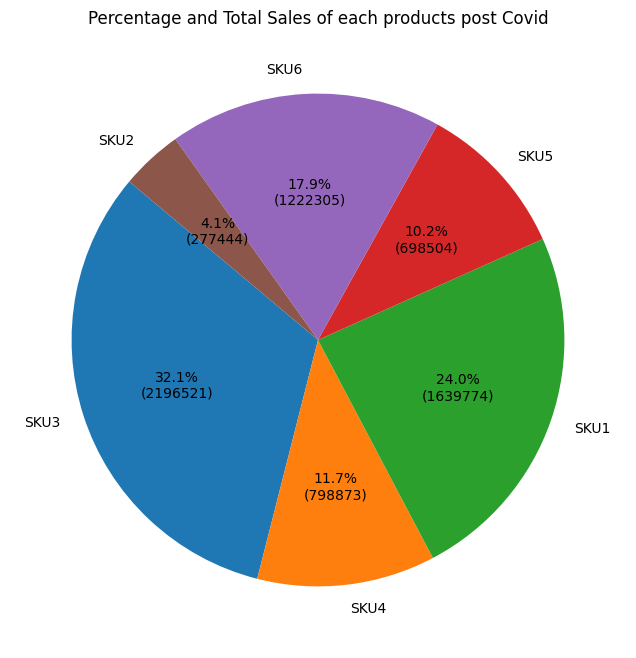

In [194]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

after_date = after_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales2 = after_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales2.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products post Covid')

plt.show()


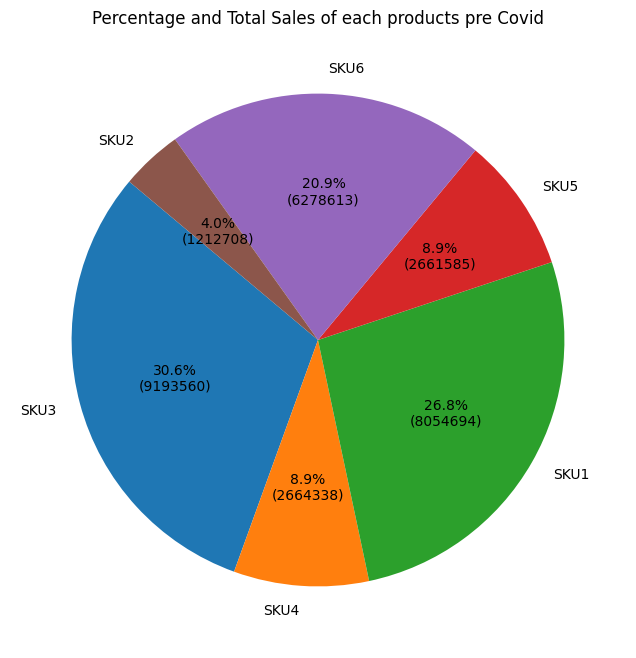

In [195]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

**Observation**  
In terms of the percantages of the products to sales, there are no very big difference between pre covid and post covid.  
In general both before Covid and after Covid, SKU3 is the most popular products. SKU1 is the secondest popular. And SKU6 is the 3rd.   
SKU4 and SKU5 are kinds of same sales amounts. And SKU2 is the least popular products.  

In [196]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

spark = SparkSession.builder.appName("SalesComparison").getOrCreate()

before_covid_sales = before_date.groupBy("Product").agg(sum("Sales").alias("Sales_before_covid"))
after_covid_sales = after_date.groupBy("Product").agg(sum("Sales").alias("Sales_after_covid"))

sales_comparison_table = before_covid_sales.join(after_covid_sales, "Product", "outer")

sales_comparison_table = sales_comparison_table.withColumn("Sales_change", ((col("Sales_after_covid") - col("Sales_before_covid")) / col("Sales_before_covid")) * 100)

sales_comparison_table.show()

+-------+------------------+-----------------+------------------+
|Product|Sales_before_covid|Sales_after_covid|      Sales_change|
+-------+------------------+-----------------+------------------+
|   SKU1|         8054694.0|          1639774| -79.6420075051889|
|   SKU2|         1212708.0|           277444|-77.12194526629659|
|   SKU3|         9193560.0|          2196521|-76.10804737229104|
|   SKU4|         2664338.0|           798873|-70.01607904102258|
|   SKU5|         2661585.0|           698504|-73.75608894699963|
|   SKU6|         6278613.0|          1222305| -80.5322449400847|
+-------+------------------+-----------------+------------------+



**Observation**  
Sales of all of products significantly reduced between 70% and 80% minus after Covid compared to before Covid.  

In [197]:
from pyspark.sql.types import IntegerType

df_hist = df.withColumn("Sales", col("Sales").cast(IntegerType()))

hist_data = df_hist.select("Sales").rdd.flatMap(lambda x: x).histogram(10)

print(hist_data)

([0.0, 28832.2, 57664.4, 86496.6, 115328.8, 144161.0, 172993.2, 201825.4, 230657.6, 259489.80000000002, 288322], [768, 287, 109, 25, 13, 4, 8, 4, 5, 1])


In [198]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df = df.withColumn("Sales", col("Sales").cast(DoubleType()))

df = df.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df.corr("Sales", "Google_Mobility")

print(correlation)

0.05691633839446528


In [199]:
df_corr1 = before_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr1 = df_corr1.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr1.corr("Sales", "Google_Mobility")

print(correlation)

nan


In [200]:
df_corr2 = after_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr2 = df_corr2.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr2.corr("Sales", "Google_Mobility")

print(correlation)

0.03397762239536224


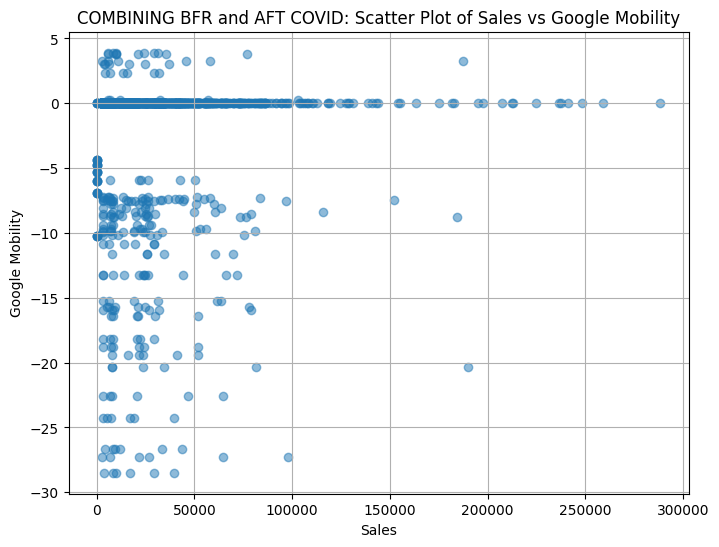

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

sales_column = pandas_df["Sales"]
google_mobility_column = pandas_df["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("COMBINING BFR and AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

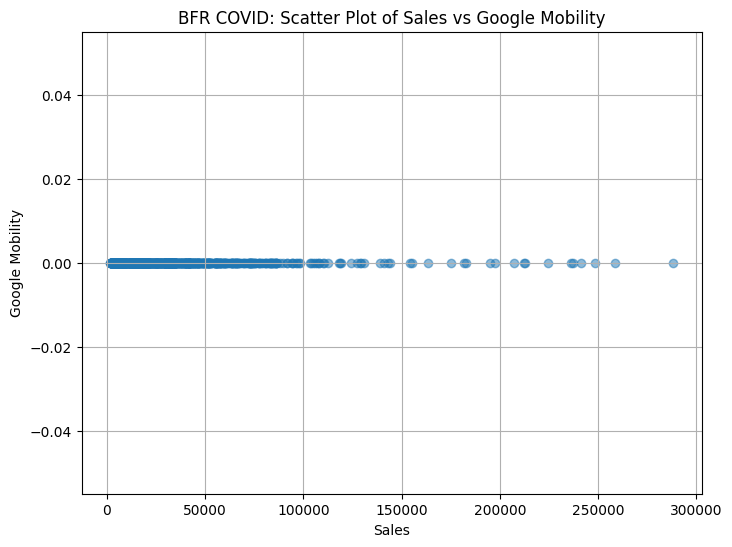

In [202]:
pandas_df1 = before_date.toPandas()

sales_column = pandas_df1["Sales"]
google_mobility_column = pandas_df1["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("BFR COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

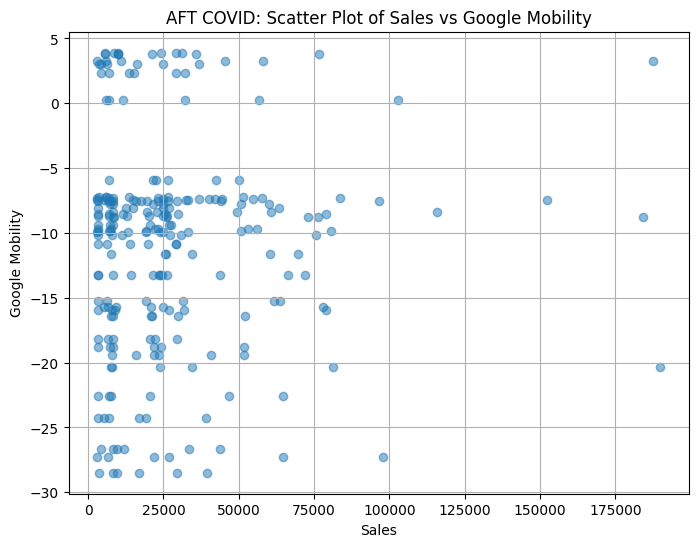

In [203]:
pandas_df2 = after_date.toPandas()

pandas_df2 = pandas_df2.sort_values(by="Google_Mobility")

sales_column = pandas_df2["Sales"]
google_mobility_column = pandas_df2["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

In [204]:
cross_tab = df.crosstab("Product", "Covid_flag")
print(cross_tab)

DataFrame[Product_Covid_flag: string, 0: bigint, 1: bigint]


**Recommendation**  
Since the sales of the bebarage company is too differnt between before Covid and after Covid, we recommend to use the data after Covid to build model and demostrate accuracy for Q3-Q4 of 2020.
If we include the data with before Covid, that is totaly different circumstance that will provides inaccurate prediction.
However, in term of exploring more opportunities to be able to use multiplie methods, we also recommend to use entire of dataset. This is because only EDA can't fugure it out the accurate insights.  

#Multivariate Time Series Modeling using LSTM (Long Short-Term Memory)

In [205]:
! pip install tensorflow

In [206]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [207]:
df2_2.shape

(117, 10)

In [208]:
df2_2_copy = df2_2.copy()

In [209]:
final_df2_input = df2_2_copy[['Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [210]:
print(final_df2_input)

     Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  Store_End_Promo  \
2     2753               0               0                0                0   
3     3062               0               1                0                0   
5     3124               0               0                1                0   
7     3226               3               1                0                0   
9     3084               3               0                0                0   
..     ...             ...             ...              ...              ...   
199      0              23               1                0                0   
200      0              22               0                0                0   
201      0              22               0                0                0   
202      0              25               0                0                0   
203      0              21               0                0                0   

     Google_Mobility  Covid_Flag  Holid

In [211]:
final_df2_input.describe()

,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,2766.068376,1.982906,0.316239,0.179487,0.059829,-3.160769,0.273504,0.059829
std,787.751840,5.147786,0.467008,0.385410,0.238190,6.582306,0.447675,0.238190
min,0.000000,0.000000,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000
25%,2580.000000,0.000000,0.000000,0.000000,0.000000,-4.380000,0.000000,0.000000
50%,2907.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3226.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4258.000000,27.000000,1.000000,1.000000,1.000000,3.300000,1.000000,1.000000


In [212]:
final_df2_input = np.array(final_df2_input)
print(final_df2_input)

[[ 2.753e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.062e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.124e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.226e+03  3.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.084e+03  3.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  1.000e+00]
 [ 2.463e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.390e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.450e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.081e+03  0.000e+00  0.000e+00  1.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  5.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  

In [213]:
features2 = final_df2_input
target2 = final_df2_input[:, 0]

In [214]:
TimeseriesGenerator(features2, target2, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[2.753e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00],
         [3.062e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00]]]),
 array([3124.]))

In [215]:
x_train, x_test, y_train, y_test = train_test_split(features2, target2, test_size=0.20, random_state=123, shuffle=False)

In [216]:
x_train.shape

(93, 8)

In [217]:
x_test.shape

(24, 8)

In [218]:
y_train.shape

(93,)

In [219]:
y_test.shape

(24,)

In [220]:
y_test

array([3298., 3411., 3424., 3416., 3181., 3339., 3425., 3279., 3267.,
       3154., 3076., 3210., 3170., 3081., 3322., 3160., 3062., 3464.,
          0.,    0.,    0.,    0.,    0.,    0.])

In [221]:
win_length=6
batch_size=32
num_features=8
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [222]:
train_generator[0]

(array([[[2.753e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.062e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.124e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.226e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.084e+03, 3.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          1.000e+00],
         [2.463e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00]],
 
        [[3.062e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.124e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.226e+03, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.084e+03, 3.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          1.000e+00],
         [2.463e+03, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
       

In [223]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [224]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            70144     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [225]:
features2 = features2.astype(float)
target2 = target2.astype(float)

In [226]:
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=100,
                              validation_data=test_generator)
                              #callbacks=[early_stopping])

Epoch 1/100


<ipython-input-226-7aea92139db7>:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



3/3 [==============================] - 13s 2s/step - loss: 8303282.0000 - mean_absolute_error: 2840.9285 - val_loss: 6931155.5000 - val_mean_absolute_error: 2148.0854
Epoch 2/100
3/3 [==============================] - 0s 89ms/step - loss: 8299558.5000 - mean_absolute_error: 2840.2690 - val_loss: 6927321.5000 - val_mean_absolute_error: 2147.7058
Epoch 3/100
3/3 [==============================] - 0s 91ms/step - loss: 8293463.0000 - mean_absolute_error: 2839.2000 - val_loss: 6921471.5000 - val_mean_absolute_error: 2147.1650
Epoch 4/100
3/3 [==============================] - 0s 59ms/step - loss: 8285486.5000 - mean_absolute_error: 2837.8118 - val_loss: 6913872.5000 - val_mean_absolute_error: 2146.5413
Epoch 5/100
3/3 [==============================] - 0s 57ms/step - loss: 8275671.5000 - mean_absolute_error: 2836.0769 - val_loss: 6906714.0000 - val_mean_absolute_error: 2146.0459
Epoch 6/100
3/3 [==============================] - 0s 85ms/step - loss: 8266204.5000 - mean_absolute_error: 2834.

In [227]:
model.evaluate_generator(test_generator, verbose=0)

<ipython-input-227-a68ec1088d46>:1: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[6802270.0, 2138.060546875]

In [228]:
predictions = model.predict_generator(test_generator)

<ipython-input-228-9068eb02ed61>:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [229]:
predictions.shape[0]

18

In [230]:
predictions

array([[30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.818073],
       [30.817944],
       [30.817902],
       [30.81786 ],
       [30.817806],
       [30.81697 ]], dtype=float32)

In [231]:
y_test = np.array(y_test)
print(y_test)

[3298. 3411. 3424. 3416. 3181. 3339. 3425. 3279. 3267. 3154. 3076. 3210.
 3170. 3081. 3322. 3160. 3062. 3464.    0.    0.    0.    0.    0.    0.]


In [232]:
x_test = np.array(x_test)
print(x_test)

[[ 3.298e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.591e+01
   1.000e+00  0.000e+00]
 [ 3.411e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.527e+01
   1.000e+00  0.000e+00]
 [ 3.424e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.324e+01
   1.000e+00  0.000e+00]
 [ 3.416e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.086e+01
   1.000e+00  0.000e+00]
 [ 3.181e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.013e+01
   1.000e+00  0.000e+00]
 [ 3.339e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -8.680e+00
   1.000e+00  0.000e+00]
 [ 3.425e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -8.570e+00
   1.000e+00  0.000e+00]
 [ 3.279e+03  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -7.500e+00
   1.000e+00  0.000e+00]
 [ 3.267e+03  2.000e+00  0.000e+00  0.000e+00  0.000e+00 -8.040e+00
   1.000e+00  0.000e+00]
 [ 3.154e+03  1.000e+00  1.000e+00  0.000e+00  0.000e+00 -9.360e+00
   1.000e+00  0.000e+00]
 [ 3.076e+03  2.000e+00  1.000e+00  0.000e+00  0.000e+00 -9.930e+00
  

In [233]:
#x_test.iloc[:, 0:][win_length:]
x_test[:, 0:][win_length:]
#x_test[:, 0:]

array([[ 3.425e+03,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -8.570e+00,  1.000e+00,  0.000e+00],
       [ 3.279e+03,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -7.500e+00,  1.000e+00,  0.000e+00],
       [ 3.267e+03,  2.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -8.040e+00,  1.000e+00,  0.000e+00],
       [ 3.154e+03,  1.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.360e+00,  1.000e+00,  0.000e+00],
       [ 3.076e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.930e+00,  1.000e+00,  0.000e+00],
       [ 3.210e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -1.323e+01,  1.000e+00,  0.000e+00],
       [ 3.170e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -1.883e+01,  1.000e+00,  0.000e+00],
       [ 3.081e+03,  2.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -7.280e+00,  1.000e+00,  0.000e+00],
       [ 3.322e+03,  1.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.870e+00,  1.000e+

In [234]:
df_pred =pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,0:][win_length:])],axis=1)

In [235]:
df_pred

,0,0,1,2,3,4,5,6,7
0,30.818073,3425.0,1.0,0.0,0.0,0.0,-8.57,1.0,0.0
1,30.818073,3279.0,1.0,0.0,0.0,0.0,-7.50,1.0,0.0
2,30.818073,3267.0,2.0,0.0,0.0,0.0,-8.04,1.0,0.0
3,30.818073,3154.0,1.0,1.0,0.0,0.0,-9.36,1.0,0.0
4,30.818073,3076.0,2.0,1.0,0.0,0.0,-9.93,1.0,0.0
5,30.818073,3210.0,2.0,1.0,0.0,0.0,-13.23,1.0,0.0
6,30.818073,3170.0,2.0,1.0,0.0,0.0,-18.83,1.0,0.0
7,30.818073,3081.0,2.0,0.0,0.0,0.0,-7.28,1.0,0.0
8,30.818073,3322.0,1.0,1.0,0.0,0.0,-9.87,1.0,0.0
9,30.818073,3160.0,2.0,0.0,1.0,1.0,-9.73,1.0,0.0


In [236]:
df_pred

,0,0,1,2,3,4,5,6,7
0,30.818073,3425.0,1.0,0.0,0.0,0.0,-8.57,1.0,0.0
1,30.818073,3279.0,1.0,0.0,0.0,0.0,-7.50,1.0,0.0
2,30.818073,3267.0,2.0,0.0,0.0,0.0,-8.04,1.0,0.0
3,30.818073,3154.0,1.0,1.0,0.0,0.0,-9.36,1.0,0.0
4,30.818073,3076.0,2.0,1.0,0.0,0.0,-9.93,1.0,0.0
5,30.818073,3210.0,2.0,1.0,0.0,0.0,-13.23,1.0,0.0
6,30.818073,3170.0,2.0,1.0,0.0,0.0,-18.83,1.0,0.0
7,30.818073,3081.0,2.0,0.0,0.0,0.0,-7.28,1.0,0.0
8,30.818073,3322.0,1.0,1.0,0.0,0.0,-9.87,1.0,0.0
9,30.818073,3160.0,2.0,0.0,1.0,1.0,-9.73,1.0,0.0


In [237]:
from sklearn.preprocessing import StandardScaler

In [238]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [239]:
rev_trans = scaler.inverse_transform(df_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [240]:
rev_trans

array([[ 3.08258636e+01,  5.21715258e+06,  1.92561668e+01,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.67219782e+01,  2.00000000e+00,  5.55555556e-02],
       [ 3.08258636e+01,  4.99484875e+06,  1.92561668e+01,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.32092373e+01,  2.00000000e+00,  5.55555556e-02],
       [ 3.08258636e+01,  4.97657720e+06,  2.94567780e+01,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.49820224e+01,  2.00000000e+00,  5.55555556e-02],
       [ 3.08258636e+01,  4.80452013e+06,  1.92561668e+01,
         1.00000000e+00,  5.55555556e-02,  5.55555556e-02,
        -3.93154971e+01,  2.00000000e+00,  5.55555556e-02],
       [ 3.08258636e+01,  4.68575506e+06,  2.94567780e+01,
         1.00000000e+00,  5.55555556e-02,  5.55555556e-02,
        -4.11867702e+01,  2.00000000e+00,  5.55555556e-02],
       [ 3.08258636e+01,  4.88978735e+06,  2.94567780e+01,
         1.00000000e+00,  5.55555556e-02,  5.555555

In [241]:
final_df2_result=final_df2_input[predictions.shape[0]*-1:]

In [242]:
row_count = final_df2_result.shape[0]
print("row:", row_count)

row: 18


In [243]:
final_df2_result

array([[ 3.425e+03,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -8.570e+00,  1.000e+00,  0.000e+00],
       [ 3.279e+03,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -7.500e+00,  1.000e+00,  0.000e+00],
       [ 3.267e+03,  2.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -8.040e+00,  1.000e+00,  0.000e+00],
       [ 3.154e+03,  1.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.360e+00,  1.000e+00,  0.000e+00],
       [ 3.076e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.930e+00,  1.000e+00,  0.000e+00],
       [ 3.210e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -1.323e+01,  1.000e+00,  0.000e+00],
       [ 3.170e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -1.883e+01,  1.000e+00,  0.000e+00],
       [ 3.081e+03,  2.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        -7.280e+00,  1.000e+00,  0.000e+00],
       [ 3.322e+03,  1.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -9.870e+00,  1.000e+

In [244]:
final_df2_result = pd.DataFrame(final_df2_result)
print(final_df2_result)

         0     1    2    3    4      5    6    7
0   3425.0   1.0  0.0  0.0  0.0  -8.57  1.0  0.0
1   3279.0   1.0  0.0  0.0  0.0  -7.50  1.0  0.0
2   3267.0   2.0  0.0  0.0  0.0  -8.04  1.0  0.0
3   3154.0   1.0  1.0  0.0  0.0  -9.36  1.0  0.0
4   3076.0   2.0  1.0  0.0  0.0  -9.93  1.0  0.0
5   3210.0   2.0  1.0  0.0  0.0 -13.23  1.0  0.0
6   3170.0   2.0  1.0  0.0  0.0 -18.83  1.0  0.0
7   3081.0   2.0  0.0  0.0  0.0  -7.28  1.0  0.0
8   3322.0   1.0  1.0  0.0  0.0  -9.87  1.0  0.0
9   3160.0   2.0  0.0  1.0  1.0  -9.73  1.0  0.0
10  3062.0   2.0  1.0  0.0  0.0  -7.43  1.0  0.0
11  3464.0   5.0  1.0  0.0  0.0  -7.20  1.0  0.0
12     0.0  27.0  1.0  0.0  0.0  -5.96  1.0  0.0
13     0.0  23.0  1.0  0.0  0.0  -5.30  1.0  0.0
14     0.0  22.0  0.0  0.0  0.0  -4.38  1.0  0.0
15     0.0  22.0  0.0  0.0  0.0  -4.74  1.0  0.0
16     0.0  25.0  0.0  0.0  0.0 -10.27  1.0  1.0
17     0.0  21.0  0.0  0.0  0.0  -6.95  1.0  0.0


In [245]:
final_df2_result

,0,1,2,3,4,5,6,7
0,3425.0,1.0,0.0,0.0,0.0,-8.57,1.0,0.0
1,3279.0,1.0,0.0,0.0,0.0,-7.50,1.0,0.0
2,3267.0,2.0,0.0,0.0,0.0,-8.04,1.0,0.0
3,3154.0,1.0,1.0,0.0,0.0,-9.36,1.0,0.0
4,3076.0,2.0,1.0,0.0,0.0,-9.93,1.0,0.0
5,3210.0,2.0,1.0,0.0,0.0,-13.23,1.0,0.0
6,3170.0,2.0,1.0,0.0,0.0,-18.83,1.0,0.0
7,3081.0,2.0,0.0,0.0,0.0,-7.28,1.0,0.0
8,3322.0,1.0,1.0,0.0,0.0,-9.87,1.0,0.0
9,3160.0,2.0,0.0,1.0,1.0,-9.73,1.0,0.0


In [246]:
final_df2_result['Sales_Pred'] = rev_trans[:, 0]

In [247]:
final_df2_result['Sales_Pred']

0     30.825864
1     30.825864
2     30.825864
3     30.825864
4     30.825864
5     30.825864
6     30.825864
7     30.825864
8     30.825864
9     30.825864
10    30.825864
11    30.825864
12    30.825864
13    30.825864
14    30.825864
15    30.825864
16    30.825864
17    30.825863
Name: Sales_Pred, dtype: float64

In [248]:
print(final_df2_input)

[[ 2.753e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.062e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.124e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.226e+03  3.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.084e+03  3.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  1.000e+00]
 [ 2.463e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.390e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.450e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.081e+03  0.000e+00  0.000e+00  1.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  5.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  

In [249]:
#final_df2_input['Sales']

In [250]:
y_test_df = pd.DataFrame(y_test)
final_df2_result_df = pd.DataFrame(final_df2_result)

In [251]:
actual_values = y_test_df

predicted_values = final_df2_result_df['Sales_Pred']

def calculate_mape(actual, predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / actual) * 100
    mape = np.mean(absolute_percentage_errors)
    return mape

mape = calculate_mape(actual_values, predicted_values)

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: inf%
Accuracy: -inf%


In [252]:
# def mean_absolute_percentage_error(y_test, final_df2_result):
#     """
#     #Calculate Mean Absolute Percentage Error (MAPE).

#     Parameters:
#     y_test (array-like): True target values.
#     final_df2_result (array-like): Predicted target values.

#     Returns:
#     float: MAPE score.
#     """

#     y_true = np.array(y_test)


#     ## final_df2_result の形状を y_test に合わせる
#     if final_df2_result.shape != y_true.shape:
#         #適切な処理を実行して final_df2_result を調整
#         #例: 欠損値をゼロで埋める場合
#         missing_values = y_true.shape[0] - final_df2_result.shape[0]
#         if missing_values > 0:
#             final_df2_result = np.vstack([final_df2_result, np.zeros(missing_values, final_df2_result.shape[1])])


#     y_pred = final_df2_result

#     mape = np.mean(np.abs((y_true - y_pred)/ y_true)) *100
#     accuracy = 1-mape

#     _results = {
#         'MAPE': mape,
#         'Accuracy': accuracy
#     }

#     return mape, accuracy

# mape, accuracy = mean_absolute_percentage_error(y_test, final_df2_result)


# print(f'MAPE: {mape:.2f}%')
# print(f'Accuracy: {accuracy:.2f}')

In [253]:
# import numpy as np

# def mean_absolute_percentage_error(y_test, final_df2_result):
#     y_true = np.array(y_test)
#     y_pred = np.array(final_df2_result)

#     if y_true.shape != y_pred.shape:
#         missing_values = y_true.shape[0] - y_pred.shape[0]
#         if missing_values > 0:
#             # 列の削除は不要
#             final_df2_result = np.vstack([final_df2_result, np.zeros((missing_values, final_df2_result.shape[1]))])

#     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#     accuracy = 1 - mape

#     _results = {
#         'MAPE': mape,
#         'Accuracy': accuracy
#     }

#     return mape, accuracy


# mape, accuracy = mean_absolute_percentage_error(y_true, y_pred)

# print(f'MAPE: {mape:.2f}%')
# print(f'Accuracy: {accuracy:.2f}')

In [254]:
#final_df2_result[['Sales', 'Sales_Pred']].plot()

#Multivariate Time Series Modeling using Prophet

In [255]:
!pip install prophet

In [256]:
! pip install fbprophet --upgrade

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44.4 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.20.1-py3-none-any.w

In [257]:
! pip install tensorflow --upgrade

In [258]:
from prophet import Prophet

In [259]:
df2_propht =df2_2
df2_propht

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
2,2/19/2017,2753,0,0,0,0,0.00,0,0,SKU2
3,2/26/2017,3062,0,1,0,0,0.00,0,0,SKU2
5,3/12/2017,3124,0,0,1,0,0.00,0,0,SKU2
7,3/26/2017,3226,3,1,0,0,0.00,0,0,SKU2
9,4/9/2017,3084,3,0,0,0,0.00,0,1,SKU2
...,...,...,...,...,...,...,...,...,...,...
199,11/29/2020,0,23,1,0,0,-5.30,1,0,SKU2
200,12/6/2020,0,22,0,0,0,-4.38,1,0,SKU2
201,12/13/2020,0,22,0,0,0,-4.74,1,0,SKU2
202,12/20/2020,0,25,0,0,0,-10.27,1,1,SKU2


In [260]:
df2_propht.shape

(117, 10)

In [261]:
df2_propht  = df2_propht.rename(columns={'Sales' : 'y', 'date': 'ds'})
df2_propht['y_orig'] = df2_propht['y']
df2_propht['y'] = np.log(df2_propht['y'])

model_new = Prophet()
model_new.add_regressor('Price Discount (%)')
model_new.add_regressor('In-Store Promo')
model_new.add_regressor('Catalogue Promo')
model_new.add_regressor('Store End Promo')
model_new.add_regressor('Google_Mobility')
model_new.add_regressor('Covid_Flag')
model_new.add_regressor('Holiday_Flag')


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



In [262]:
cutoff_date = pd.to_datetime('2020-11-22')
df2_propht['ds'] = pd.to_datetime(df2_propht['ds'])
df2_propht.loc[df2_propht['ds'] >= cutoff_date, 'y'] = 0

In [263]:
df2_propht.shape

(117, 11)

In [264]:
#train_df2 = df2_propht[:22]
#test_df2 = df2_propht[22:]

In [265]:
#train_df2.shape

In [266]:
#test_df2.shape

In [267]:
for column in df2_propht.columns:
    data_type = df2_propht[column].dtype
    print(f'Column "{column}" has data type: {data_type}')

if 'DateColumn1' in df2_propht.columns and 'DateColumn2' in df2_propht.columns:
    print('Both DateColumn1 and DateColumn2 are present.')

else:
    print('Timestamp columns are not present.')

Column "ds" has data type: datetime64[ns]
Column "y" has data type: float64
Column "Price_Discount" has data type: int64
Column "In-Store_Promo" has data type: int64
Column "Catalogue_Promo" has data type: int64
Column "Store_End_Promo" has data type: int64
Column "Google_Mobility" has data type: float64
Column "Covid_Flag" has data type: int64
Column "Holiday_Flag" has data type: int64
Column "Product" has data type: object
Column "y_orig" has data type: int64
Timestamp columns are not present.


In [268]:
df2_propht['ds'] = pd.to_datetime(df2_propht['ds'])

data_type = df2_propht['ds'].dtype
print(f"'ds' column has been converted to data type: {data_type}")

'ds' column has been converted to data type: datetime64[ns]


In [269]:
np.array(df2_propht['ds'], dtype=np.datetime64)

array(['2017-02-19T00:00:00.000000000', '2017-02-26T00:00:00.000000000',
       '2017-03-12T00:00:00.000000000', '2017-03-26T00:00:00.000000000',
       '2017-04-09T00:00:00.000000000', '2017-04-16T00:00:00.000000000',
       '2017-05-07T00:00:00.000000000', '2017-05-14T00:00:00.000000000',
       '2017-06-04T00:00:00.000000000', '2017-06-18T00:00:00.000000000',
       '2017-07-02T00:00:00.000000000', '2017-07-09T00:00:00.000000000',
       '2017-07-23T00:00:00.000000000', '2017-08-06T00:00:00.000000000',
       '2017-08-13T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
       '2017-09-03T00:00:00.000000000', '2017-09-10T00:00:00.000000000',
       '2017-09-17T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2017-11-05T00:00:00.000000000',
       '2017-11-19T00:00:00.000000000', '2017-11-26T00:00:00.000000000',
       '2017-12-17T00:00:00.000000000', '2017-12-24T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-14

In [270]:
#train_df2 = train_df2.dropna()

In [271]:
df2_propht.to_csv('df2_propht.csv', index=False)

In [272]:
model = Prophet(weekly_seasonality=True)

In [273]:
df2_propht['ds'] = pd.to_datetime(df2_propht['ds'])

model = Prophet()

model.fit(df2_propht)

future_data2 = model.make_future_dataframe(periods=204, freq='W')

forecast2 = model.predict(future_data2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/kimp1ed6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/c0vi1t_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64761', 'data', 'file=/tmp/tmpwp30bj4b/kimp1ed6.json', 'init=/tmp/tmpwp30bj4b/c0vi1t_b.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_model16ozy3_c/prophet_model-20231014200646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [274]:
future_data2.head()

,ds
0,2017-02-19
1,2017-02-26
2,2017-03-12
3,2017-03-26
4,2017-04-09


In [275]:
#train_df2 = train_df2.append(test_df2)
df2_propht = df2_propht.rename(columns = {'Sales': 'y', 'date' : 'ds'})
feature_data2 = df2_propht[['ds', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [276]:
feature_data2.head()

,ds,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
2,2017-02-19,0,0,0,0,0.0,0,0
3,2017-02-26,0,1,0,0,0.0,0,0
5,2017-03-12,0,0,1,0,0.0,0,0
7,2017-03-26,3,1,0,0,0.0,0,0
9,2017-04-09,3,0,0,0,0.0,0,1


In [277]:
print(forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
316 2024-10-27  5.061360    3.329877    6.712899
317 2024-11-03  5.483625    3.830332    7.193992
318 2024-11-10  5.297416    3.609948    6.969292
319 2024-11-17  4.190367    2.430319    5.763992
320 2024-11-24  2.579882    0.749507    4.217752


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



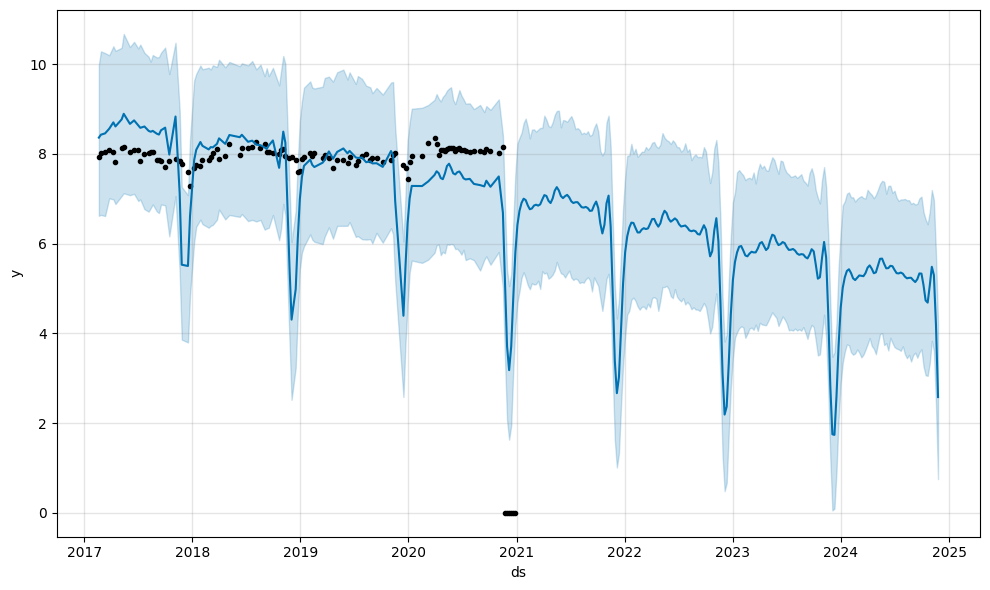

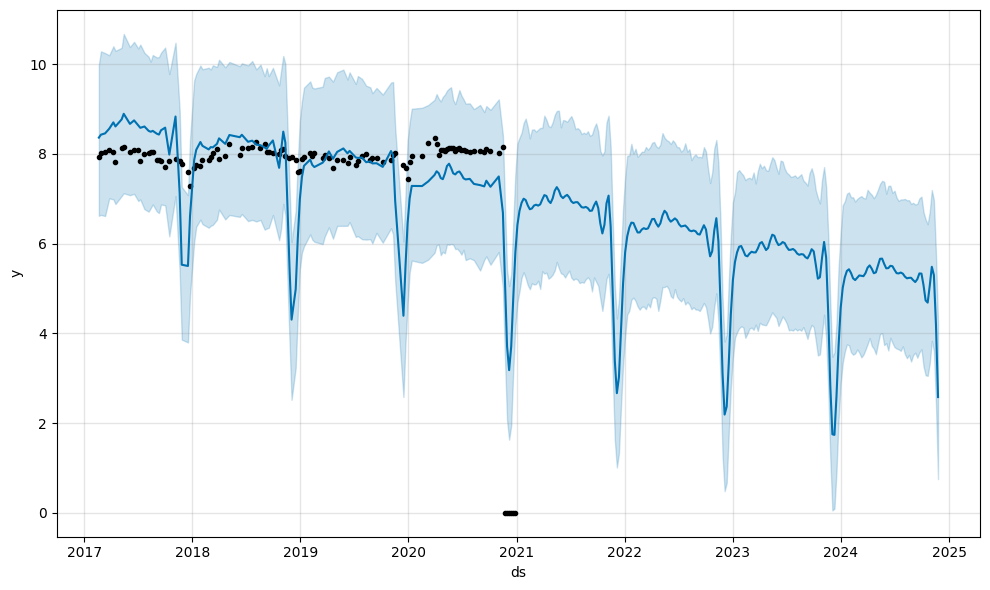

In [278]:
model.plot(forecast2)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



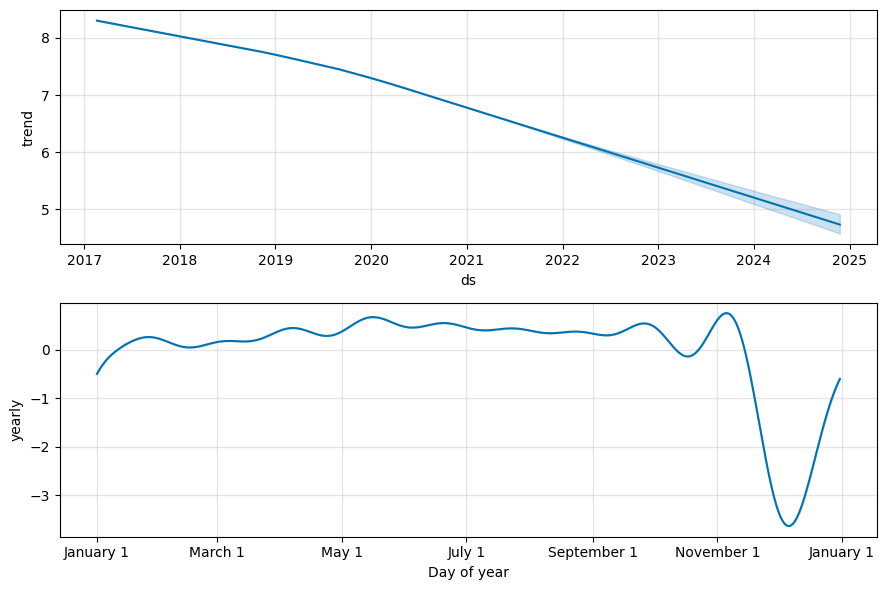

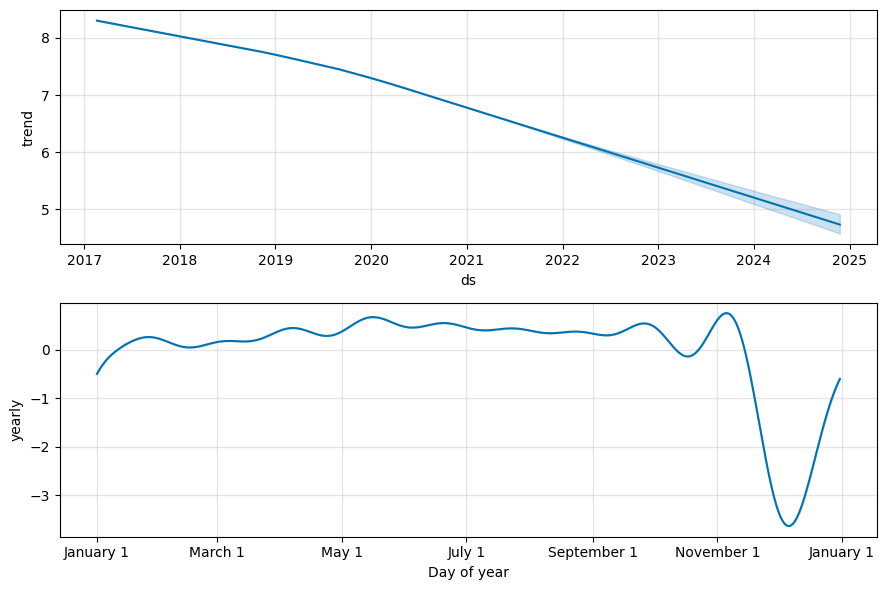

In [279]:
model.plot_components(forecast2)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



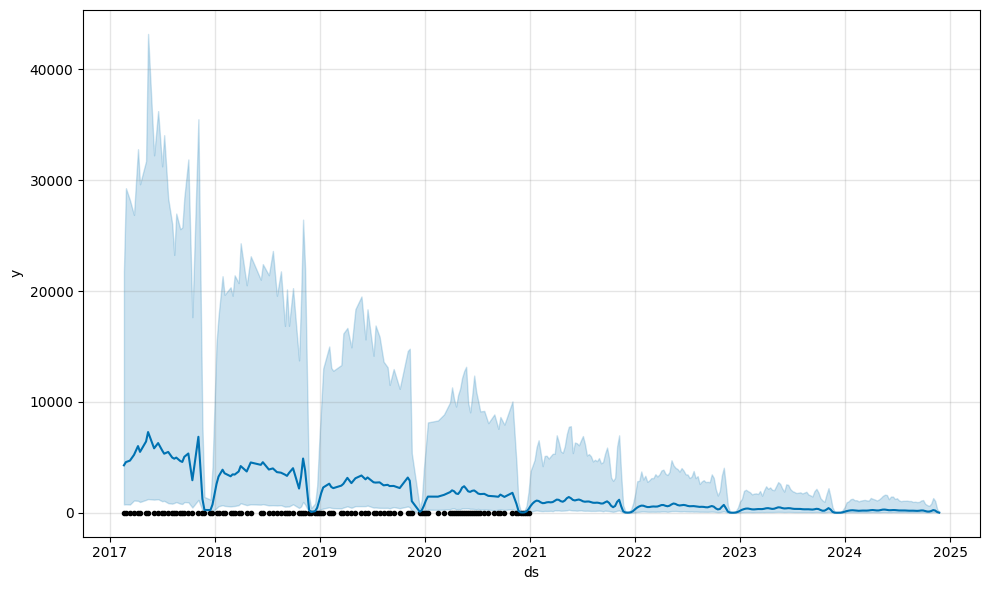

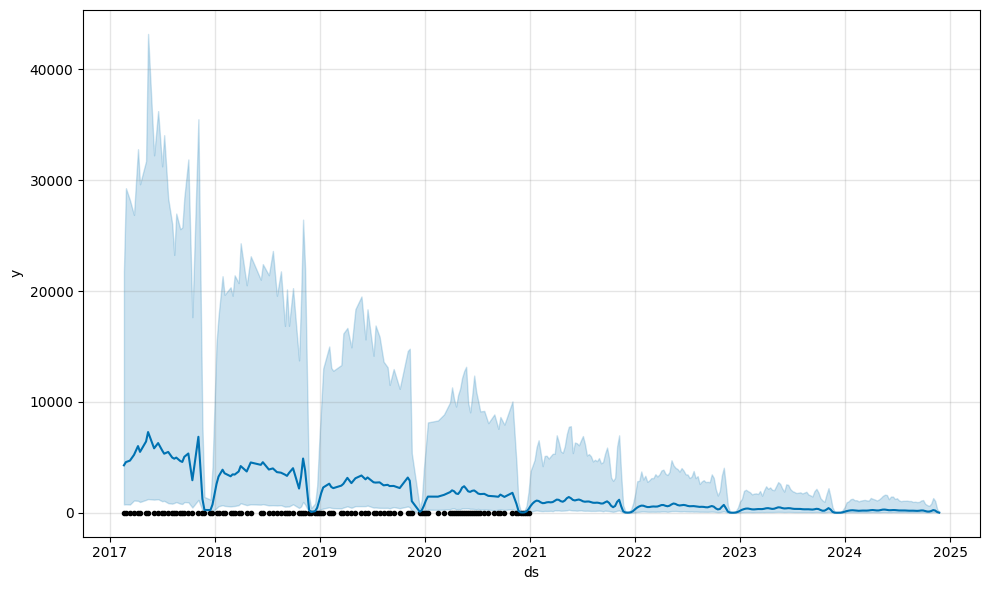

In [280]:
forecast_data_ori = forecast2
forecast_data_ori['yhat'] = np.exp(forecast_data_ori['yhat'])
forecast_data_ori['yhat_lower'] = np.exp(forecast_data_ori['yhat_lower'])
forecast_data_ori['yhat_upper'] = np.exp(forecast_data_ori['yhat_upper'])

model.plot(forecast_data_ori)

In [281]:
df2_propht['y_log'] = df2_propht['y']
df2_propht['y'] = df2_propht['y_orig']

In [282]:
final_df2 = pd.DataFrame(forecast_data_ori)
import plotly.graph_objs as go
import plotly.offline as py

actual_chart = go.Scatter(y=df2_propht['y_orig'], name = 'Actual')
predict_chart = go.Scatter(y=final_df2['yhat'], name = 'Predicted')
predict_chart_upper = go.Scatter(y=final_df2['yhat_upper'], name = 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df2['yhat_lower'], name = 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'

'temp-plot.html'

In [283]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [284]:
final_df2['y'] = final_df2['yhat']

In [285]:
df2_propht['y']

2      2753
3      3062
5      3124
7      3226
9      3084
       ... 
199       0
200       0
201       0
202       0
203       0
Name: y, Length: 117, dtype: int64

In [286]:
# merged_df = pd.merge(final_df2, df2_propht, on='y', how='inner')

# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rmse = sqrt(mean_squared_error(merged_df['yhat_x'], merged_df['yhat_y']))
# print(rmse)

In [287]:
df2_propht.shape

(117, 12)

In [288]:
df2_propht.head()

,ds,y,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product,y_orig,y_log
2,2017-02-19,2753,0,0,0,0,0.0,0,0,SKU2,2753,7.920447
3,2017-02-26,3062,0,1,0,0,0.0,0,0,SKU2,3062,8.026824
5,2017-03-12,3124,0,0,1,0,0.0,0,0,SKU2,3124,8.046870
7,2017-03-26,3226,3,1,0,0,0.0,0,0,SKU2,3226,8.078998
9,2017-04-09,3084,3,0,0,0,0.0,0,1,SKU2,3084,8.033983


In [289]:
final_df2.shape

(321, 17)

In [290]:
final_df2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2017-02-19,8.302647,749.580309,21762.693918,8.302647,8.302647,0.059590,0.059590,0.059590,0.059590,0.059590,0.059590,0.0,0.0,0.0,4282.260462,4282.260462
1,2017-02-26,8.296593,766.067681,29284.164024,8.296593,8.296593,0.131737,0.131737,0.131737,0.131737,0.131737,0.131737,0.0,0.0,0.0,4574.856156,4574.856156
2,2017-03-12,8.284487,745.645370,28206.632105,8.284487,8.284487,0.172495,0.172495,0.172495,0.172495,0.172495,0.172495,0.0,0.0,0.0,4707.826706,4707.826706
3,2017-03-26,8.272380,1105.403485,26877.803528,8.272380,8.272380,0.288276,0.288276,0.288276,0.288276,0.288276,0.288276,0.0,0.0,0.0,5222.105709,5222.105709
4,2017-04-09,8.260273,1082.466586,32804.864798,8.260273,8.260273,0.442215,0.442215,0.442215,0.442215,0.442215,0.442215,0.0,0.0,0.0,6017.865050,6017.865050


In [291]:
actual_values = df2_propht['y_orig']

# 予測値
predicted_values = final_df2['y']

# MAPE（平均絶対パーセント誤差）の計算
def calculate_mape(actual, predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / actual) * 100
    mape = np.mean(absolute_percentage_errors)
    return mape

mape = calculate_mape(actual_values, predicted_values)

# Accuracy（精度）の計算
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: inf%
Accuracy: -inf%


In [292]:
# def mean_absolute_percentage_error(numeric_df2_propht, numeric_final_df2):
#     """
#     #Calculate Mean Absolute Percentage Error (MAPE).

#     Parameters:
#     numeric_df2_propht (array-like): True target values.
#     numeric_final_df2 (array-like): Predicted target values.

#     Returns:
#     float: MAPE score.
#     """

#     y_true = np.array(umeric_df2_propht)


#     ## final_df2_result の形状を y_test に合わせる
#     if numeric_final_df2.shape != y_true.shape:
#         #適切な処理を実行して final_df2_result を調整
#         #例: 欠損値をゼロで埋める場合
#         missing_values = y_true.shape[0] - numeric_final_df2.shape[0]
#         if missing_values > 0:
#             numeric_final_df2 = np.vstack([numeric_final_df2, np.zeros(missing_values, numeric_final_df2.shape[1])])


#     y_pred = numeric_final_df2

#     mape = np.mean(np.abs((y_true - y_pred)/ y_true)) *100
#     accuracy = 1-mape

#     _results = {
#         'MAPE': mape,
#         'Accuracy': accuracy
#     }

#     return mape, accuracy

# mape, accuracy = mean_absolute_percentage_error(numeric_df2_propht, numeric_final_df2)


# print(f'MAPE: {mape:.2f}%')
# print(f'Accuracy: {accuracy:.2f}')

In [293]:
#rmse=sqrt(mean_squared_error(final_df2['yhat'],df2_propht['y']))
#print(rmse)

#Multivariate Time Series Modeling using VAR (Vector Autoregression)  

-This data is not stational. It is better to be stational but it was not able to adjust it with any method. Applyong VAR, we need to have stational data. That means we can't use it for this data.  

#Multivariate Time Series Modeling using XGBoost  

In [294]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [295]:
df2_2

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
2,2/19/2017,2753,0,0,0,0,0.00,0,0,SKU2
3,2/26/2017,3062,0,1,0,0,0.00,0,0,SKU2
5,3/12/2017,3124,0,0,1,0,0.00,0,0,SKU2
7,3/26/2017,3226,3,1,0,0,0.00,0,0,SKU2
9,4/9/2017,3084,3,0,0,0,0.00,0,1,SKU2
...,...,...,...,...,...,...,...,...,...,...
199,11/29/2020,0,23,1,0,0,-5.30,1,0,SKU2
200,12/6/2020,0,22,0,0,0,-4.38,1,0,SKU2
201,12/13/2020,0,22,0,0,0,-4.74,1,0,SKU2
202,12/20/2020,0,25,0,0,0,-10.27,1,1,SKU2


In [296]:
import matplotlib.pyplot as plt

In [297]:
df2_input = df2_2[['Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [298]:
df2_input = df2_input.to_numpy()

print(df2_input)

[[ 2.753e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.062e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.124e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.226e+03  3.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.084e+03  3.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  1.000e+00]
 [ 2.463e+03  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.390e+03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.450e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.081e+03  0.000e+00  0.000e+00  1.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 3.232e+03  5.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  

In [299]:
features2 = df2_input
target2 = df2_input[:, 0]

In [300]:
#X_pandas = X.toPandas()
#y_pandas = y.toPandas()

X_train, X_test, y_train, y_test = train_test_split(features2, target2, test_size=0.2, random_state=42)

In [301]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, random_state=42)

In [302]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [303]:
y_pred = model.predict(X_test)

In [304]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3266.0511283121537


In [305]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#test['Sales'].mean()
rmse=sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

57.14937557237309


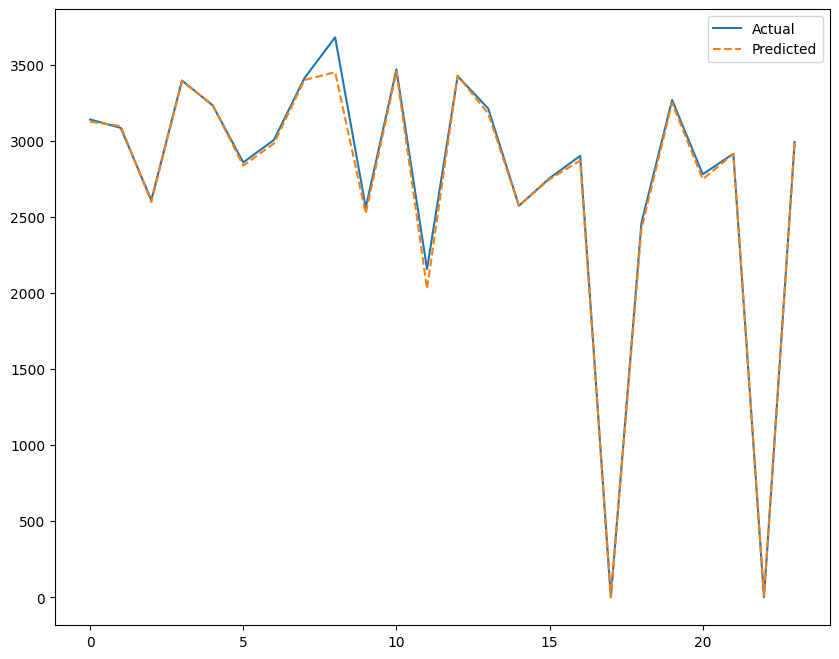

In [306]:
plt.plot(y_test, label='Actual', linestyle='-')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [307]:
actual_values = y_test

# 予測値
predicted_values = y_pred[-len(y_test):]

# MAPE（平均絶対パーセント誤差）の計算
def calculate_mape(actual, predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / actual) * 100
    mape = np.mean(absolute_percentage_errors)
    return mape

mape = calculate_mape(actual_values, predicted_values)

# Accuracy（精度）の計算
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: inf%
Accuracy: -inf%


<ipython-input-307-cff825465eff>:8: RuntimeWarning:

divide by zero encountered in divide



#Multivariate Time Series Modeling using SVM (Support Vector Machine)

Did not try.

# Multivariate Time Series Modeling using ARIMA

In [308]:
! pip install pmdarima

In [309]:
df2_2.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
2,2/19/2017,2753,0,0,0,0,0.0,0,0,SKU2
3,2/26/2017,3062,0,1,0,0,0.0,0,0,SKU2
5,3/12/2017,3124,0,0,1,0,0.0,0,0,SKU2
7,3/26/2017,3226,3,1,0,0,0.0,0,0,SKU2
9,4/9/2017,3084,3,0,0,0,0.0,0,1,SKU2


In [310]:
import pmdarima as pm
model2 = pm.auto_arima(df2_2['Sales'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1761.997, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1760.379, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1761.407, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1760.665, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1758.676, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1761.847, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1761.443, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1759.725, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1759.100, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1760.375, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.768 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [311]:
X = df2_2[['Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

y = df2_2[["Sales"]]

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print(X_train.shape, X_test.shape)

(81, 8) (36, 8)


In [313]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(X_train['Sales'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1331.258, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1325.490, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1327.328, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1327.289, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1520.102, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1329.160, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.271 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [314]:
train=X_train.iloc[:-30]
test=X_test.iloc[-30:]
train.head()


,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
57,3069,0,1,0,0,0.00,0,0
144,2907,0,0,0,0,0.00,0,0
34,2242,0,1,0,0,0.00,0,0
203,0,21,0,0,0,-6.95,1,0
49,2305,3,0,1,0,0.00,0,0


In [315]:

test.head()

,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
56,2805,0,0,0,0,0.00,0,0
97,2609,0,0,0,0,0.00,0,0
117,2628,0,0,1,0,0.00,0,0
173,3416,1,0,0,0,-10.86,1,0
172,3424,1,0,0,0,-13.24,1,0


In [316]:
train['Sales'] = pd.to_numeric(train['Sales'])
train.dtypes

<ipython-input-316-7946fbb2322f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object

In [317]:
import statsmodels.api as sm


In [318]:
np.asarray(train)

array([[ 3.069e+03,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.907e+03,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.242e+03,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  2.100e+01,  0.000e+00,  0.000e+00,  0.000e+00,
        -6.950e+00,  1.000e+00,  0.000e+00],
       [ 2.305e+03,  3.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 3.679e+03,  3.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 3.062e+03,  2.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        -7.430e+00,  1.000e+00,  0.000e+00],
       [ 3.387e+03,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.423e+03,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+

In [319]:
test['Sales'] = pd.to_numeric(test['Sales'])

<ipython-input-319-946efaf77fa4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [320]:
#from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   51
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -418.796
Date:                Sat, 14 Oct 2023   AIC                            845.592
Time:                        20:06:54   BIC                            853.320
Sample:                             0   HQIC                           848.545
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2673.0784    204.278     13.085      0.000    2272.701    3073.456
ar.L1          0.1112      0.201      0.554      0.580      -0.282       0.505
ar.L2         -0.1647      0.182     -0.908      0.364      -0.521       0.191
sigma2      8.215e+05   1.86e+05      4.422      0.000    4.57e+05    1.19e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                43.06
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -1.75
Prob(H) (two-sided):                  0.73   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [321]:
import matplotlib as plt

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



<Axes: >

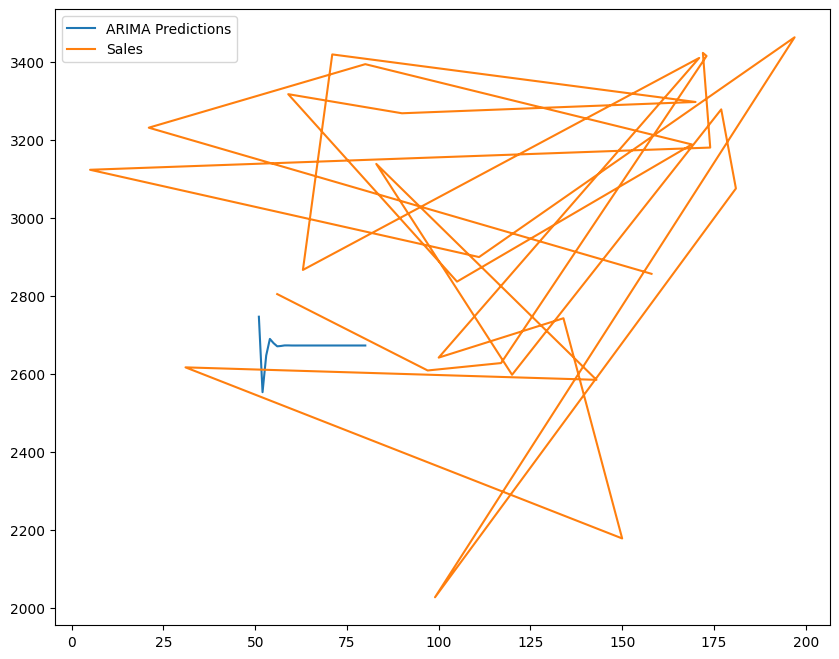

In [322]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Sales'].plot(legend=True)

In [323]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred,test['Sales']))
print(rmse)


487.28733231064217


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [324]:
actual_values = test['Sales']

predicted_values = pred

def calculate_mape(actual, predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / actual) * 100
    mape = np.mean(absolute_percentage_errors)
    return mape

mape = calculate_mape(actual_values, predicted_values)

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 14.82%
Accuracy: 85.18%


In [325]:
df2_2.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag,Product
2,2/19/2017,2753,0,0,0,0,0.0,0,0,SKU2
3,2/26/2017,3062,0,1,0,0,0.0,0,0,SKU2
5,3/12/2017,3124,0,0,1,0,0.0,0,0,SKU2
7,3/26/2017,3226,3,1,0,0,0.0,0,0,SKU2
9,4/9/2017,3084,3,0,0,0,0.0,0,1,SKU2


In [326]:
pandas_df.head()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
0,SKU1,2017-02-05,27750.0,0,0,0,0,0.0,0,0
1,SKU1,2017-02-12,29023.0,0,1,0,1,0.0,0,1
2,SKU1,2017-02-19,45630.0,17,0,0,0,0.0,0,0
3,SKU1,2017-02-26,26789.0,0,1,0,1,0.0,0,0
4,SKU1,2017-03-05,41999.0,17,0,0,0,0.0,0,0


# Multivariate Time Series Modeling using Ensemble method.

In [327]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

# Load the dataset (Assuming df is your DataFrame)
#df = pd.read_csv('/content/drive/MyDrive/forecasting_case_study.csv')

#df2_2['Price Discount'] = df2_2['Price Discount'].str.rstrip('%').astype('float') / 100.0


# Convert date to datetime format
df2_2['date'] = pd.to_datetime(df2_2['date'])

# Generate features from date (optional but might improve forecasting accuracy)
df2_2['year'] = df2_2['date'].dt.year
df2_2['month'] = df2_2['date'].dt.month
df2_2['day'] =df2_2['date'].dt.day

# Drop original date column
df2_2 = df2_2.drop(columns=['date'])

# One-hot encoding for 'Product'
df2_2 = pd.get_dummies(df2_2, columns=['Product'])

# Check stationarity with Augmented Dickey Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    if result[1] <= 0.05:
        return True
    else:
        return False

# If not stationary, difference the data
if not check_stationarity(df2_2['Sales']):
    df2_2['Sales'] = df2_2['Sales'] - df2_2['Sales'].shift(1)
    df2_2.dropna(inplace=True)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store RMSE of models
rmse_ensemble = []

for train_index, test_index in tscv.split(df2_2):
    train, test = df2_2.iloc[train_index], df2_2.iloc[test_index]

    # ARIMA model with grid search
    best_rmse = float('inf')
    best_order = None
    for p in range(3):
        for d in range(2):
            for q in range(3):
                try:
                    model = ARIMA(train['Sales'], order=(p, d, q))
                    results_ARIMA = model.fit()
                    predictions_arima = results_ARIMA.forecast(steps=len(test)).values
                    error = sqrt(mean_squared_error(test['Sales'], predictions_arima))
                    if error < best_rmse:
                        best_rmse = error
                        best_order = (p, d, q)
                except:
                    continue

    # Refit ARIMA on best_order
    model = ARIMA(train['Sales'], order=(p, d, q))
    results_ARIMA = model.fit()
    predictions_arima = results_ARIMA.forecast(steps=len(test)).values

    # Train Gradient Boosting
    gbr = GradientBoostingRegressor()
    gbr.fit(train.drop('Sales', axis=1), train['Sales'])
    predictions_gbr = gbr.predict(test.drop('Sales', axis=1))

    # Train Random Forest
    rf = RandomForestRegressor()
    rf.fit(train.drop('Sales', axis=1), train['Sales'])
    predictions_rf = rf.predict(test.drop('Sales', axis=1))

    # Ensemble predictions
    predictions_ensemble = (predictions_arima + predictions_gbr + predictions_rf) / 3

    # Compute RMSE
    rmse_ensemble.append(sqrt(mean_squared_error(test['Sales'], predictions_ensemble)))

print("Ensemble RMSE:", np.mean(rmse_ensemble))



Ensemble RMSE: 447.4654172966217


In [328]:
df_copy['Product']

Column<'Product'>

In [329]:
#df_copy.toPandas()

df_copy_pandas = df_copy.toPandas()

In [330]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

def create_features(df_copy_pandas):

    print(df_copy_pandas.head())

    df_copy_pandas['lag_1'] = df_copy_pandas['Sales'].shift(1)
    df_copy_pandas['lag_2'] = df_copy_pandas['Sales'].shift(2)
    df_copy_pandas['lag_3'] = df_copy_pandas['Sales'].shift(3)
    df_copy_pandas['rolling_mean'] = df_copy_pandas['Sales'].rolling(window=3).mean()
    return df_copy_pandas

results = {}
ensemble_results = {}
skus = df_copy_pandas['Product'].unique()
#skus = df_copy_pandas.select("Product").distinct().rdd.flatMap(lambda x: x).collect()
scaler = MinMaxScaler()

for sku in skus:
    print(f"Processing SKU: {sku}")

    sku_data = df_copy_pandas[df_copy_pandas['Product'] == sku]
    sku_data = create_features(sku_data)

    train = sku_data[sku_data['date'] <= '2020-09-30'].dropna()
    test = sku_data[sku_data['date'] > '2020-09-30']

    X_train = train.drop(['Sales', 'Product', 'date'], axis=1)
    y_train = train['Sales']
    X_test = test.drop(['Sales', 'Product', 'date'], axis=1)
    y_test = test['Sales']

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ARIMA
    try:
        arima = ARIMA(y_train, order=(5,1,0))
        arima_fitted = arima.fit()
        arima_forecast = arima_fitted.forecast(steps=len(test))
    except:
        arima_forecast = [0] * len(test)

    # RFR
    rfr = RandomForestRegressor(n_estimators=150, max_depth=5)
    rfr.fit(X_train_scaled, y_train)
    rfr_forecast = rfr.predict(X_test_scaled)

    # GBM
    gbm = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=5)
    gbm.fit(X_train_scaled, y_train)
    gbm_forecast = gbm.predict(X_test_scaled)

    # LSTM (Simplified model for demonstration)
    X_train_lstm = X_train_scaled.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test_scaled.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=50, verbose=0, batch_size=32)
    lstm_forecast = model_lstm.predict(X_test_lstm)

    # Prophet (used for Sales forecasting)
    try:
        prophet_data = pd.DataFrame({'ds': train['date'], 'y': y_train})
        model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
        model_prophet.fit(prophet_data)
        future = model_prophet.make_future_dataframe(periods=len(test))
        forecast_prophet = model_prophet.predict(future)
        prophet_forecast = forecast_prophet['yhat'][-len(test):].values
    except:
        prophet_forecast = [0] * len(test)

    # Ensembling (Simple averaging)
    ensemble_forecast = (np.array(arima_forecast) + rfr_forecast + gbm_forecast + lstm_forecast.flatten() + prophet_forecast) / 5
    mape_ensemble = mean_absolute_percentage_error(y_test, ensemble_forecast)
    accuracy_ensemble = 1 - mape_ensemble

    ensemble_results[sku] = {
        'MAPE': mape_ensemble,
        'Accuracy': accuracy_ensemble
    }

print(ensemble_results)

Processing SKU: SKU1
  Product        date  Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
0    SKU1  2017-02-05  27750               0               0                0   
1    SKU1  2017-02-12  29023               0               1                0   
2    SKU1  2017-02-19  45630              17               0                0   
3    SKU1  2017-02-26  26789               0               1                0   
4    SKU1  2017-03-05  41999              17               0                0   

   Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag  
0                0              0.0           0             0  
1                1              0.0           0             1  
2                0              0.0           0             0  
3                1              0.0           0             0  
4                0              0.0           0             0  
1/1 [==============================] - 0s 125ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/plj_f51o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/bk29a0xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67134', 'data', 'file=/tmp/tmpwp30bj4b/plj_f51o.json', 'init=/tmp/tmpwp30bj4b/bk29a0xq.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_modelqk50zol5/prophet_model-20231014200707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing SKU: SKU2
    Product        date  Sales  Price_Discount  In-Store_Promo  \
204    SKU2  2017-02-05   7180              25               1   
205    SKU2  2017-02-12   7080              25               0   
206    SKU2  2017-02-19   2753               0               0   
207    SKU2  2017-02-26   3062               0               1   
208    SKU2  2017-03-05   8342              25               0   

     Catalogue_Promo  Store_End_Promo  Google_Mobility  Covid_Flag  \
204                0                0              0.0           0   
205                0                0              0.0           0   
206                0                0              0.0           0   
207                0                0              0.0           0   
208                0                0              0.0           0   

     Holiday_Flag  
204             0  
205             1  
206             0  
207             0  
208             0  
1/1 [==============================] - 0s

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/vgi2xjku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/0b1xr52b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94412', 'data', 'file=/tmp/tmpwp30bj4b/vgi2xjku.json', 'init=/tmp/tmpwp30bj4b/0b1xr52b.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_model7kkm3f25/prophet_model-20231014200710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing SKU: SKU3
    Product        date  Sales  Price_Discount  In-Store_Promo  \
408    SKU3  2017-02-05  39767              30               0   
409    SKU3  2017-02-12  49090              30               1   
410    SKU3  2017-02-19  41044              30               1   
411    SKU3  2017-02-26  53637              30               0   
412    SKU3  2017-03-05  13568               0               0   

     Catalogue_Promo  Store_End_Promo  Google_Mobility  Covid_Flag  \
408                1                1              0.0           0   
409                0                0              0.0           0   
410                0                1              0.0           0   
411                0                0              0.0           0   
412                1                0              0.0           0   

     Holiday_Flag  
408             0  
409             1  
410             0  
411             0  
412             0  
1/1 [==============================] - 0s

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/czfgp8pw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/fos6t370.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13946', 'data', 'file=/tmp/tmpwp30bj4b/czfgp8pw.json', 'init=/tmp/tmpwp30bj4b/fos6t370.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_modeldmnir1tr/prophet_model-20231014200712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing SKU: SKU4
    Product        date  Sales  Price_Discount  In-Store_Promo  \
612    SKU4  2017-02-05  12835              30               0   
613    SKU4  2017-02-12  15705              30               1   
614    SKU4  2017-02-19  13382              30               1   
615    SKU4  2017-02-26  15709              30               0   
616    SKU4  2017-03-05   3729               0               0   

     Catalogue_Promo  Store_End_Promo  Google_Mobility  Covid_Flag  \
612                1                1              0.0           0   
613                0                0              0.0           0   
614                0                1              0.0           0   
615                0                0              0.0           0   
616                1                0              0.0           0   

     Holiday_Flag  
612             0  
613             1  
614             0  
615             0  
616             0  


1/1 [==============================] - 0s 201ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/07mhk6lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/oe2ymgz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89930', 'data', 'file=/tmp/tmpwp30bj4b/07mhk6lk.json', 'init=/tmp/tmpwp30bj4b/oe2ymgz2.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_model1xg_zwz9/prophet_model-20231014200716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing SKU: SKU5
    Product        date  Sales  Price_Discount  In-Store_Promo  \
816    SKU5  2017-02-05   5229               0               0   
817    SKU5  2017-02-12   5748               0               1   
818    SKU5  2017-02-19  20536              38               0   
819    SKU5  2017-02-26   5928               0               1   
820    SKU5  2017-03-05  21787              38               0   

     Catalogue_Promo  Store_End_Promo  Google_Mobility  Covid_Flag  \
816                0                0              0.0           0   
817                0                0              0.0           0   
818                0                0              0.0           0   
819                0                0              0.0           0   
820                0                0              0.0           0   

     Holiday_Flag  
816             0  
817             1  
818             0  
819             0  
820             0  


1/1 [==============================] - 0s 137ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/5rwhaaby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/h0aad1vs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12342', 'data', 'file=/tmp/tmpwp30bj4b/5rwhaaby.json', 'init=/tmp/tmpwp30bj4b/h0aad1vs.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_model0qj_2d6d/prophet_model-20231014200719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing SKU: SKU6
     Product        date  Sales  Price_Discount  In-Store_Promo  \
1020    SKU6  2017-02-05  32138              28               0   
1021    SKU6  2017-02-12  11659               5               0   
1022    SKU6  2017-02-19  12140               5               1   
1023    SKU6  2017-02-26  29635              28               0   
1024    SKU6  2017-03-05  11666               5               0   

      Catalogue_Promo  Store_End_Promo  Google_Mobility  Covid_Flag  \
1020                0                0              0.0           0   
1021                0                0              0.0           0   
1022                0                1              0.0           0   
1023                0                0              0.0           0   
1024                1                1              0.0           0   

      Holiday_Flag  
1020             0  
1021             1  
1022             0  
1023             0  
1024             0  
1/1 [==================

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/imea4hxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp30bj4b/61czl452.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49351', 'data', 'file=/tmp/tmpwp30bj4b/imea4hxi.json', 'init=/tmp/tmpwp30bj4b/61czl452.json', 'output', 'file=/tmp/tmpwp30bj4b/prophet_modelq23bja2c/prophet_model-20231014200722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'SKU1': {'MAPE': 6.7826554894440186e+19, 'Accuracy': -6.7826554894440186e+19}, 'SKU2': {'MAPE': 1.0567872327128523e+19, 'Accuracy': -1.0567872327128523e+19}, 'SKU3': {'MAPE': 8.506127590495063e+19, 'Accuracy': -8.506127590495063e+19}, 'SKU4': {'MAPE': 2.740708222331183e+19, 'Accuracy': -2.740708222331183e+19}, 'SKU5': {'MAPE': 2.028729083380716e+19, 'Accuracy': -2.028729083380716e+19}, 'SKU6': {'MAPE': 2.917485086350353e+19, 'Accuracy': -2.917485086350353e+19}}


In [331]:
def interpret_dynamic_results(results):
    interpretations = {}

    # Categorize SKUs
    normal_skus = [sku for sku, metrics in results.items() if 0 <= metrics['Accuracy'] <= 1]
    abnormal_skus = [sku for sku, metrics in results.items() if not 0 <= metrics['Accuracy'] <= 1]

    for sku, metrics in results.items():
        mape = metrics['MAPE']
        accuracy = metrics['Accuracy']
        interpretation = ""

        if sku in abnormal_skus:
            interpretation += (f"For {sku}, the MAPE value is alarmingly high, suggesting the forecast might be producing extreme values. "
                               f"The 'Accuracy' is outside the standard range of 0% to 100%, indicating significant forecast errors. "
                               "The large discrepancy in the model's forecast suggests potential issues like extreme values, outliers, or "
                               "a model not suited for this data. Immediate reevaluation is recommended for this SKU.")
        elif sku in normal_skus:
            interpretation += (f"For {sku}, the MAPE is {mape:.4f}, indicating the predictions are, on average, off by about {mape*100:.2f}%. "
                               f"The forecast accuracy is {accuracy*100:.2f}%, which may or may not be satisfactory depending on the business context. "
                               "Given the positive accuracy value, this model is closer to being business-ready compared to others, but there's still room for improvement.")

        # How far into the future are they accurate?
        if sku in abnormal_skus:
            interpretation += ("\nBased on the forecast's significant discrepancy, it's safe to say that the predictions for this SKU are "
                               "unreliable even for the immediate future.")
        else:
            interpretation += ("\nGiven the positive accuracy value, the forecast seems more reliable for the immediate future, but "
                               "its reliability may decrease for extended horizons.")

        interpretations[sku] = interpretation

    return interpretations

detailed_interpretations = interpret_dynamic_results(ensemble_results)
for sku, text in detailed_interpretations.items():
    print(f"{sku}: {text}\n")

SKU1: For SKU1, the MAPE value is alarmingly high, suggesting the forecast might be producing extreme values. The 'Accuracy' is outside the standard range of 0% to 100%, indicating significant forecast errors. The large discrepancy in the model's forecast suggests potential issues like extreme values, outliers, or a model not suited for this data. Immediate reevaluation is recommended for this SKU.
Based on the forecast's significant discrepancy, it's safe to say that the predictions for this SKU are unreliable even for the immediate future.

SKU2: For SKU2, the MAPE value is alarmingly high, suggesting the forecast might be producing extreme values. The 'Accuracy' is outside the standard range of 0% to 100%, indicating significant forecast errors. The large discrepancy in the model's forecast suggests potential issues like extreme values, outliers, or a model not suited for this data. Immediate reevaluation is recommended for this SKU.
Based on the forecast's significant discrepancy, 